# Response variable - Q26 (Confidence Level)  
   5개 category 로 fitting 한 결과 accuracy = 0.3내외 --> 매우 낮음  
   따라서 애매한 중간 카테고리를 Middle로 대체해 HIGH, MIDDLE, LOW 로 분류
  
  
- country : 대륙으로 그룹화 
  
  
- 직무 : 4가지로 그룹화   
     각 role과 confidence cor 확인 결과 data scienties, software engineer, student 외로 별다른 특성이 없어 others로 대체  
  
  
- 연봉  : I do not wish to ~~ / NA제외  
	국가와의 correlation이 높을 것으로 예상됨 - 다중공선성을 우려하여 나라별 평균 연봉 대비 비율로 계산  
	연봉의 하한선을 기준으로 계산  
    
    
- 28, 29, 30 : Google, IBM, Azure 등 기업 기준으로 그룹화  
  
  
- 34, 35 등 10단위로 나오는 변수들은 100으로 나눠 scale   
  
  
- 37제외(NA값 너무많음)  
  
  
- 다중공선성을 고려하여 correlation 0.5 이상인 변수들은 제거 :  
	['1_Male',
	 '4_Master’s degree',
 	'6_0_Others',
 	'7_I am a student',
 	'14_None',
 	'15_I have not used any cloud providers',
 	'16_R',
 	'16_MATLAB',
	 '19_Keras',
	 '19_None',
	 '21_ggplot2',
 	'21_Matplotlib',
 	'25_< 1 year',
 	'27_AWS Elastic Compute Cloud (EC2)',
 	'27_Google Compute Engine',
	 '27_Azure Virtual Machines',
	 '36_Fast.AI',
	 '42_Not applicable (I am not involved with an organization that builds ML models)',
	 '44_I have never performed this task',
	 '28_IBM',
	 '29_SQL',
	 '30_Google']
  
- Q17, 18, 20, 22, 33 은 전과 같은 이유로 제외  
  
  
- 1의 비율이 5% 이하인 column 제외  
  
  
- 총 234개 변수로 fitting
  
  
- metrics: accuracy 
- RF, Linear SVM, MLP, LDA, LightGBM으로 accuracy 산정한 결과, RF와 LightGBM이 가장 높은 성능을 보여 둘을 채택.  
- GridSearchCV를 사용해 hyperparameter tuning  
- test 결과 오버피팅은 보이지 않았음.  
  
  
- lightGBM과 RF의 feature importance를 참고하여 중요변수를 산정.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
sns.set_style('dark')

%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
data=pd.read_csv('data/responses.csv')

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
qs=pd.read_csv('data/SurveySchema.csv')

In [4]:
data.head()

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
0,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,Select the title most similar to your current ...,In what industry is your current employer/cont...,...,What tools and methods do you use to make your...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,621,Male,-1,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,...,-1,NaN,NaN,Requires too much technical knowledge,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1


In [5]:
data=data.iloc[1:,:]
data = data.reset_index()
data=data.iloc[:,1:]

In [6]:
indexna = data.Q26[data.Q26.isna()].index
indexnona = data.Q26[~data.Q26.isna()].index

In [7]:
na = data.iloc[indexna,0]
nona = data.iloc[indexnona,0]

In [8]:
na = na.reset_index().drop(['index'],axis=1)
nona = nona.reset_index().drop(['index'],axis=1)

In [9]:
na.columns = ['time']
nona.columns = ['time']

{'whiskers': [<matplotlib.lines.Line2D at 0x1f885f56408>,
 'caps': [<matplotlib.lines.Line2D at 0x1f885f56cc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f885f53848>],
 'medians': [<matplotlib.lines.Line2D at 0x1f885f59c48>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f885f5fac8>],
 'means': []}

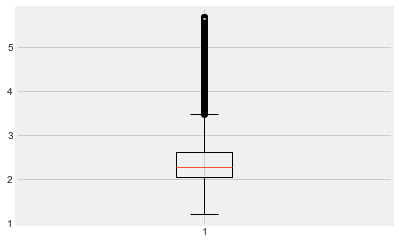

In [15]:
plt.boxplot(np.log10(list(na.iloc[:,0])))

{'whiskers': [<matplotlib.lines.Line2D at 0x1f885fb9f48>,
 'caps': [<matplotlib.lines.Line2D at 0x1f885fbfb08>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f885fb96c8>],
 'medians': [<matplotlib.lines.Line2D at 0x1f885fc2a88>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f885fc7908>],
 'means': []}

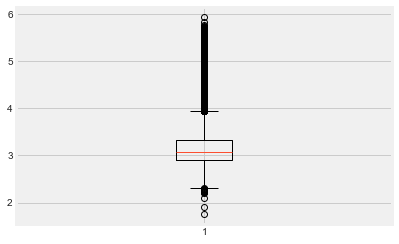

In [16]:
plt.boxplot(np.log10(list(pd.to_numeric(nona.iloc[:,0]))))

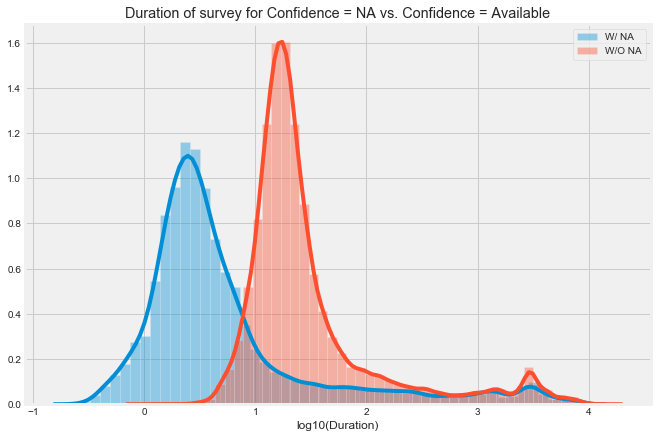

In [20]:
plt.figure(figsize=(10,7))
sns.distplot(np.log10(list(na.iloc[:,0]/60)),label='W/ NA')
sns.distplot(np.log10(list(pd.to_numeric(nona.iloc[:,0])/60)),label='W/O NA')
plt.legend()
plt.title('Duration of survey for Confidence = NA vs. Confidence = Available')
plt.xlabel('log10(Duration)')
plt.show()

NA 데이터 : e^5(=148)초에서 중단되는 경우가 다수.  
그에 반해 NA가 아닌 데이터는 응답 중단 시간이 대부분 148초를 넘어감 => NA = 테스트 도중 나가버렸을 가능성 ↑  
따라서 제외해도 무방

## Response variable - Q26 (Confidence Level)
- 5개 category 로 fitting 한 결과 accuracy = 0.3내외 --> 매우 낮음
- 따라서 애매한 중간 카테고리를 Middle로 대체해 HIGH, MIDDLE, LOW 로 분류

In [14]:
len(data.Q26[data.Q26.isna()])

5379

In [15]:
##NA값 제거
data=data.drop(data.Q26[data.Q26.isna()].index, axis=0)

In [16]:
data=data.reset_index()
data=data.iloc[:,1:]

In [17]:
data.shape

(18480, 395)

In [18]:
conf = data.Q26
conf.unique()

array(['Maybe', 'Definitely not', 'Definitely yes', 'Probably yes',
       'Probably not'], dtype=object)

In [19]:
encode = {'Definitely not':'LOW','Probably not':'MIDDLE','Maybe':'MIDDLE','Probably yes':'MIDDLE','Definitely yes':'HIGH'}
data.Q26.replace(encode,inplace = True)

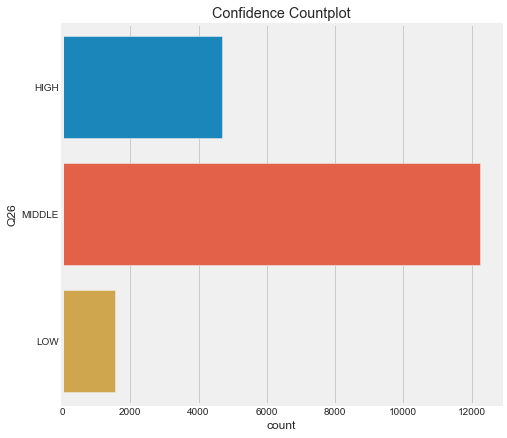

In [20]:
plt.figure(figsize=(7,7))
sns.countplot(y=data.Q26, order = ['HIGH','MIDDLE','LOW'])
plt.title('Confidence Countplot')
plt.show()

In [21]:
confdummy = pd.get_dummies(conf)

In [22]:
#numeric encoding
encode = {'LOW':0,'MIDDLE':1,'HIGH':2}
conf = conf.replace(encode)

In [23]:
new_index = ['LOW','MIDDLE','HIGH']
confdummy=confdummy.reindex(new_index, axis="columns")

In [24]:
ndata = pd.DataFrame()

## Duration(제외), Q1-Q10

In [25]:
data.Q1.unique()

array(['Female', 'Male', 'Prefer not to say', 'Prefer to self-describe'],
      dtype=object)

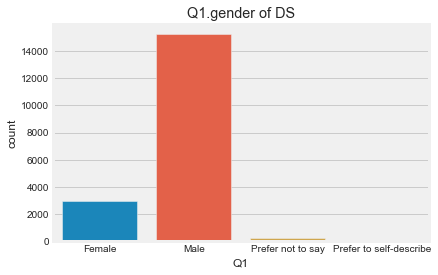

In [26]:
sns.countplot(data.Q1)
plt.title('Q1.gender of DS')
plt.show()

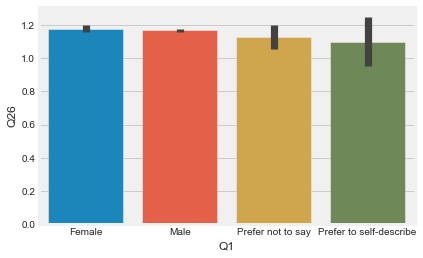

In [27]:
sns.barplot(x=data.Q1,y=conf)

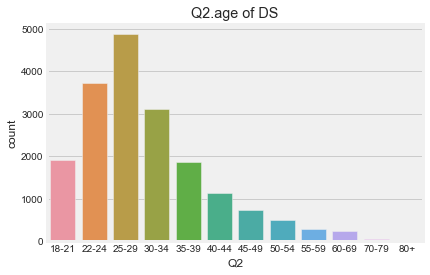

In [28]:
sns.countplot(data.Q2,order=sorted(data.Q2.unique()))
plt.title('Q2.age of DS')
plt.show()

In [29]:
# one hot encoding 후 prefer not to say, prefer to self-describe 제외
sex = pd.get_dummies(data.Q1).iloc[:,:2]
sex.columns=list(map(lambda x:'1_'+x,sex.columns))
ndata = pd.concat([ndata,sex],axis=1)
ndata.head()

,1_Female,1_Male
0,1,0
1,0,1
2,1,0
3,0,1
4,0,1


In [30]:
ndata.shape

(18480, 2)

**나이 - numeric encoding**

In [31]:
le = preprocessing.LabelEncoder()

In [32]:
le.fit(data.Q2)
le.classes_

array(['18-21', '22-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-69', '70-79', '80+'], dtype=object)

In [33]:
age = le.transform(data.Q2)
age = pd.Series(age)
age=age.rename('age')
ndata=pd.concat([ndata,age],axis=1)

In [34]:
ndata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18480 entries, 0 to 18479
Data columns (total 3 columns):
1_Female    18480 non-null uint8
1_Male      18480 non-null uint8
age         18480 non-null int32
dtypes: int32(1), uint8(2)
memory usage: 108.4 KB


**country - onehot encoding**

In [35]:
data.Q3.replace({'Republic of Korea':'South Korea'},inplace=True)

In [36]:
asia=["Bangladesh","China","Hong Kong (S.A.R.)","India","Indonesia","Iran, Islamic Republic of...","Israel",
          "Japan","Malaysia","Pakistan","Philippines","Singapore","South Korea","Thailand",
          "Turkey","Viet Nam"]
europe =["Austria","Belarus","Belgium","Czech Republic","Denmark","Finland","France","Germany","Greece",
            "Hungary","Ireland","Italy","Netherlands","Norway","Poland","Portugal","Romania","Russia","Spain",
            "Sweden","Switzerland","Ukraine","United Kingdom of Great Britain and Northern Ireland"]
southamerica =["Argentina","Brazil","Chile","Colombia","Peru"]
northamerica =["Canada","Mexico","United States of America"]
oceania =["Australia","New Zealand"]
africa =["Egypt","Kenya","Morocco","Nigeria","South Africa","Tunisia"]

In [37]:
def groupregion(x):
    if x in asia:
        x = 'Asia'
    elif x in europe:
        x = 'Europe'
    elif x in southamerica:
        x = 'SouthAmerica'
    elif x in northamerica:
        x = 'NorthAmerica'
    elif x in oceania:
        x='Oceania'
    else:
        x='Africa'
    return x

q3_grouped = [groupregion(x) for x in data.Q3]

In [38]:
q3_grouped = pd.Series(q3_grouped)

In [39]:
q3_grouped.unique()

array(['NorthAmerica', 'Asia', 'SouthAmerica', 'Europe', 'Africa',
       'Oceania'], dtype=object)

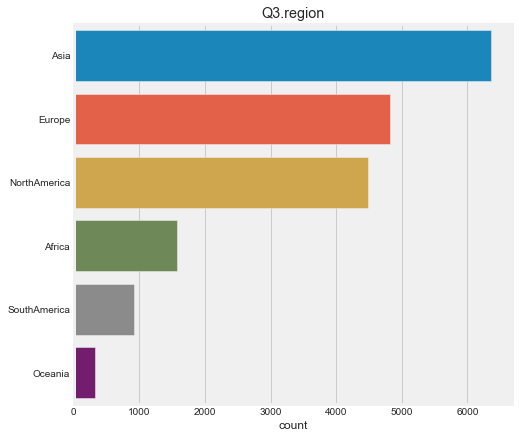

In [40]:
plt.figure(figsize=(7,7))
sns.countplot(y=q3_grouped, order =q3_grouped.value_counts().index)
plt.title('Q3.region')
plt.show()

In [41]:
q3=pd.get_dummies(q3_grouped)
cor_mat=pd.concat([confdummy,q3], axis=1, keys=['roledummy','q4']).corr().loc['roledummy','q4']

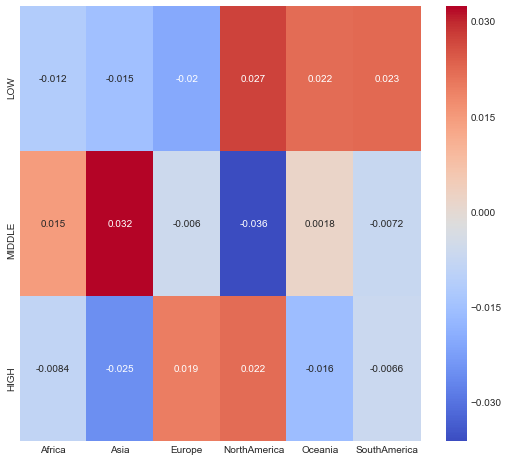

In [42]:
plt.figure(figsize=(8,8))
sns.heatmap(cor_mat,cmap='coolwarm',annot=True)
plt.show()

Africa, Asia => MIDDLE  
Europe => HIGH  
NorthAmerica => HIGH or LOW --> 자기 확신이 강함  
Oceania, SouthAmerica => LOW  

In [43]:
q3.columns=list(map(lambda x: '3_'+x,q3.columns))
ndata = pd.concat([ndata,q3],axis=1)

**education degree** - onehot

In [44]:
data.Q4.unique()

array(['Doctoral degree', 'Bachelor’s degree', 'Master’s degree',
       'Professional degree',
       'Some college/university study without earning a bachelor’s degree',
       'I prefer not to answer', 'No formal education past high school'],
      dtype=object)

In [45]:
q4 = pd.get_dummies(data.Q4)
cor_mat=pd.concat([confdummy,q4], axis=1, keys=['roledummy','q4']).corr().loc['roledummy','q4']

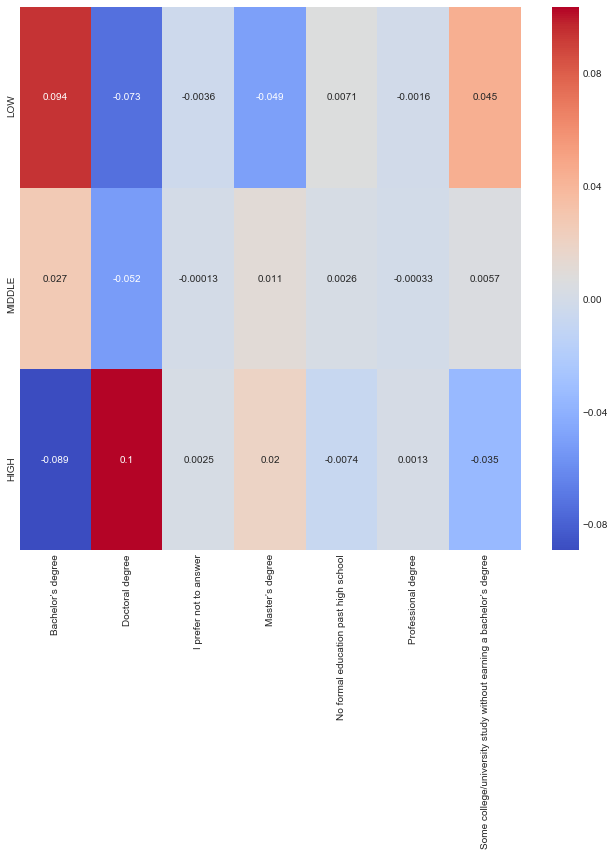

In [46]:
plt.figure(figsize=(10,10))
sns.heatmap(cor_mat,cmap='coolwarm',annot=True)
plt.show()

In [47]:
q4.columns=list(map(lambda x: '4_'+x,q4.columns))
ndata = pd.concat([ndata,q4],axis=1)

**전공**

In [48]:
data.Q5.unique()

array(['Other', 'Engineering (non-computer focused)',
       'Computer science (software engineering, etc.)',
       'Social sciences (anthropology, psychology, sociology, etc.)',
       'Mathematics or statistics', 'Physics or astronomy',
       'Information technology, networking, or system administration',
       'A business discipline (accounting, economics, finance, etc.)',
       'Environmental science or geology',
       'Medical or life sciences (biology, chemistry, medicine, etc.)',
       'I never declared a major',
       'Humanities (history, literature, philosophy, etc.)', nan,
       'Fine arts or performing arts'], dtype=object)

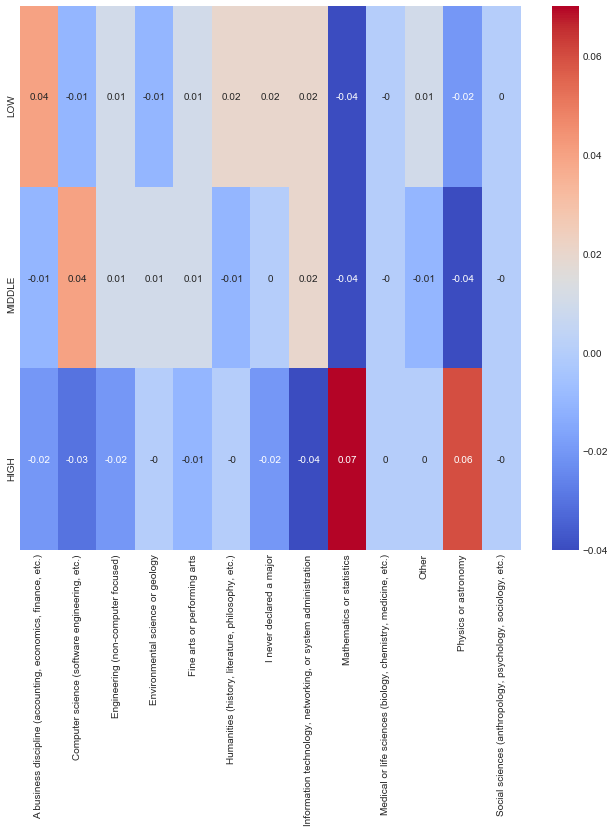

In [49]:
q5 = pd.get_dummies(data.Q5)
cor_mat=round(pd.concat([confdummy,q5],axis=1,keys=['role','q5']).corr().loc['role','q5'],2)
plt.figure(figsize=(10,10))
sns.heatmap(cor_mat, cmap='coolwarm',annot=True)

# Q6. 직무 - 4가지로 그룹화

In [50]:
def grouprole(x):
    if x not in ['Data Scientist','Software Engineer','Student']:
        return 'Others'
    else:
        return x

q6_grouped = [grouprole(x) for x in data.Q6]

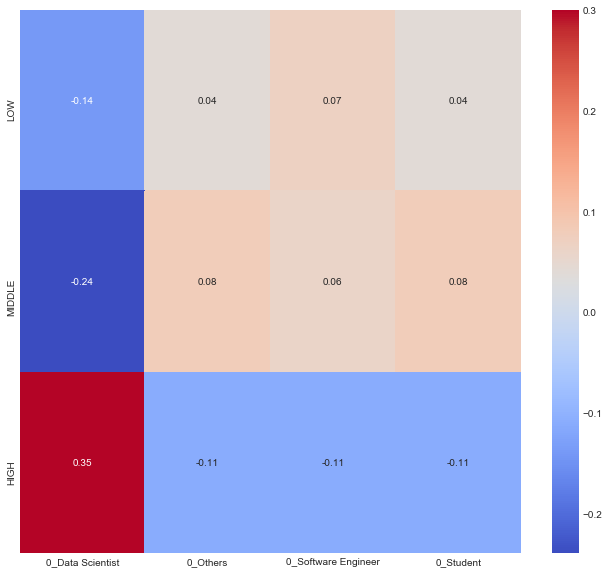

In [51]:
q6 = pd.get_dummies(pd.DataFrame(q6_grouped))
cor_mat=round(pd.concat([confdummy,q6],axis=1,keys=['role','q7']).corr().loc['role','q7'],2)
plt.figure(figsize=(10,10))
sns.heatmap(cor_mat, cmap='coolwarm',vmax=0.3,annot=True)

In [52]:
q6.columns=list(map(lambda x: '6_'+x,q6.columns))
ndata = pd.concat([ndata,q6],axis=1)

**산업군**

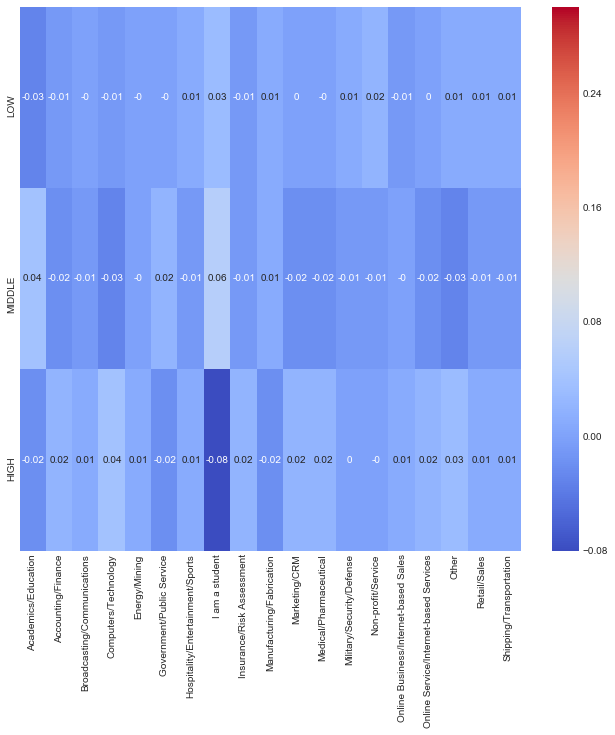

In [53]:
q7 = pd.get_dummies(data.Q7)
cor_mat=round(pd.concat([confdummy,q7],axis=1,keys=['role','q7']).corr().loc['role','q7'],2)
plt.figure(figsize=(10,10))
sns.heatmap(cor_mat, cmap='coolwarm',vmax=0.3,annot=True)

In [54]:
q7.columns=list(map(lambda x: '7_'+x,q7.columns))
ndata = pd.concat([ndata,q7],axis=1)

**경력**

In [55]:
data.Q8.unique() #range가 고르지 않아서 onehot encoding으로.

array([nan, '5-10', '0-1', '10-15', '3-4', '1-2', '2-3', '15-20', '4-5',
       '20-25', '25-30', '30 +'], dtype=object)

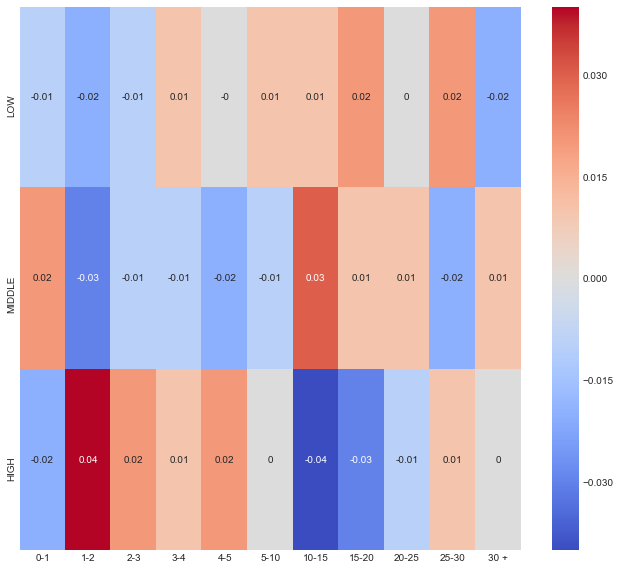

In [56]:
q8 = pd.get_dummies(data.Q8)
q8=q8.reindex(columns=['0-1','1-2','2-3','3-4','4-5','5-10','10-15','15-20', '20-25', '25-30', '30 +' ])
cor_mat=round(pd.concat([confdummy,q8],axis=1,keys=['role','q']).corr().loc['role','q'],2)
plt.figure(figsize=(10,10))
sns.heatmap(cor_mat, cmap='coolwarm',annot=True)

In [57]:
q8.columns=list(map(lambda x: '8_'+x,q8.columns))
ndata = pd.concat([ndata,q8],axis=1)

**연봉**
 - I do not wish to ~~ / NA제외
 - 국가와의 correlation이 높을 것으로 예상됨 - 다중공선성을 우려하여 나라별 평균 연봉 대비 비율로 계산
 - 연봉의 하한선을 기준으로 계산

In [58]:
gni = pd.read_csv('gni.csv')

In [59]:
data.Q9.unique()

array([nan, '10-20,000', '0-10,000',
       'I do not wish to disclose my approximate yearly compensation',
       '20-30,000', '125-150,000', '30-40,000', '50-60,000',
       '100-125,000', '90-100,000', '70-80,000', '80-90,000', '60-70,000',
       '400-500,000', '40-50,000', '150-200,000', '500,000+',
       '300-400,000', '200-250,000', '250-300,000'], dtype=object)

In [60]:
ndata = ndata[~data.Q9.isna()]
ndata = ndata[data.Q9!='I do not wish to disclose my approximate yearly compensation']
data = data[~data.Q9.isna()]
data = data[data.Q9!='I do not wish to disclose my approximate yearly compensation']

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [61]:
data.shape

(13406, 395)

In [62]:
ndata.shape

(13406, 50)

In [63]:
data.Q9.unique()

array(['10-20,000', '0-10,000', '20-30,000', '125-150,000', '30-40,000',
       '50-60,000', '100-125,000', '90-100,000', '70-80,000', '80-90,000',
       '60-70,000', '400-500,000', '40-50,000', '150-200,000', '500,000+',
       '300-400,000', '200-250,000', '250-300,000'], dtype=object)

In [64]:
encode = {'10-20,000':10000, '0-10,000':0, '20-30,000':20000, '125-150,000':125000, '30-40,000':30000,
       '50-60,000':50000, '100-125,000':100000, '90-100,000':90000, '70-80,000':70000, '80-90,000':80000,
       '60-70,000':60000, '400-500,000':400000, '40-50,000':40000, '150-200,000':150000, '500,000+':500000,
       '300-400,000':300000, '200-250,000':200000, '250-300,000':250000}
data.Q9.replace(encode, inplace =True)

In [65]:
data.Q9.unique()

array([ 10000,      0,  20000, 125000,  30000,  50000, 100000,  90000,
        70000,  80000,  60000, 400000,  40000, 150000, 500000, 300000,
       200000, 250000], dtype=int64)

In [66]:
df = data[['Q3','Q9']]
df.columns = ['country','Q9']
df.head()

,country,Q9
1,Indonesia,10000
2,United States of America,0
4,India,0
6,Chile,10000
7,India,0


In [67]:
df = df.join(gni.set_index('country'), on='country')
q9 = df.Q9/df.salary
q9

1        2.785515
2        0.000000
4        0.000000
6        0.724988
7        0.000000
           ...   
18471    1.027046
18472    5.415162
18473    0.000000
18475    1.861684
18479    6.340350
Length: 13406, dtype: float64

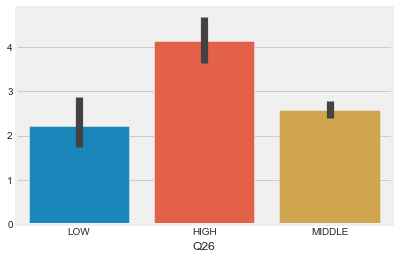

In [68]:
d = pd.concat([data.Q26,q9],axis=1)
sns.barplot(x=data.Q26, y=q9,data=d)

상관관계 존재

In [69]:
q9.name='salary'
ndata=pd.concat([ndata,q9],axis=1)

**Q10**

In [70]:
data.Q10.unique()

array(['No (we do not use ML methods)', 'I do not know',
       'We recently started using ML methods (i.e., models in production for less than 2 years)',
       'We have well established ML methods (i.e., models in production for more than 2 years)',
       'We are exploring ML methods (and may one day put a model into production)',
       'We use ML methods for generating insights (but do not put working models into production)'],
      dtype=object)

In [71]:
encode={'I do not know':0, 'No (we do not use ML methods)':0, 
       'We use ML methods for generating insights (but do not put working models into production)':1,
       'We are exploring ML methods (and may one day put a model into production)':2,
       'We recently started using ML methods (i.e., models in production for less than 2 years)':3,
       'We have well established ML methods (i.e., models in production for more than 2 years)':4}
q10=data.Q10.copy()
q10=q10.replace(encode)
q10[q10.isna()]=0
ndata = pd.concat([ndata,q10],axis=1)

In [72]:
ndata.shape

(13406, 52)

## Q11-

In [73]:
# data = data.drop([t for t in data.columns if 'OTHER_TEXT' in t],axis=1)  

In [74]:
def to_onehot(i):
    num = 'Q'+str(i)
    q=data[[t for t in data.columns if num in t]]
    q = q.drop([t for t in q.columns if 'OTHER_TEXT' in t],axis=1)  
    q=q.fillna(0)
    q_r = []
    for col in q.columns:
        if q[col].unique()[0]!=0:
            s = q[col].unique()[0]
            q_r.append(s)
        else:
            s = q[col].unique()[1]
            q_r.append(s)
        q[col]=q[col].replace(s,1)
    q.columns=q_r
    return q

## Q11

In [75]:
q11=to_onehot(11)
q11=q11.idxmax(axis=1)
q11.head()

# data=data.drop(['Q11_OTHER_TEXT'],axis=1)
# data[[t for t in data.columns if 'Q11' in t]]=to_onehot(11)
# data[[t for t in data.columns if 'Q11' in t]].head()

1    None of these activities are an important part...
2    Analyze and understand data to influence produ...
4                                                Other
6    None of these activities are an important part...
7    Build and/or run a machine learning service th...
dtype: object

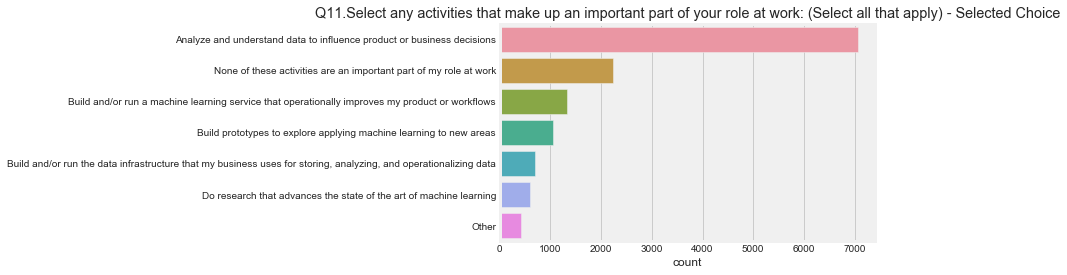

In [76]:
order=q11.value_counts(ascending=False).index
sns.countplot(y=q11,order=order)
plt.title('Q11.' + qs.iloc[0,11+1])
plt.show()

In [77]:
q11=to_onehot(11)
q11.columns = ['11_'+str(col) for col in q11.columns]
q11.head()

,11_Analyze and understand data to influence product or business decisions,11_Build and/or run a machine learning service that operationally improves my product or workflows,"11_Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",11_Build prototypes to explore applying machine learning to new areas,11_Do research that advances the state of the art of machine learning,11_None of these activities are an important part of my role at work,11_Other
1,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1
6,0,0,0,0,0,1,0
7,0,1,0,0,0,0,0


In [78]:
#Add None of these & Others - to others
q11.iloc[:,-1]=q11.iloc[:,-2]+q11.iloc[:,-1]
q11=q11.drop(q11.columns[-2],axis=1)

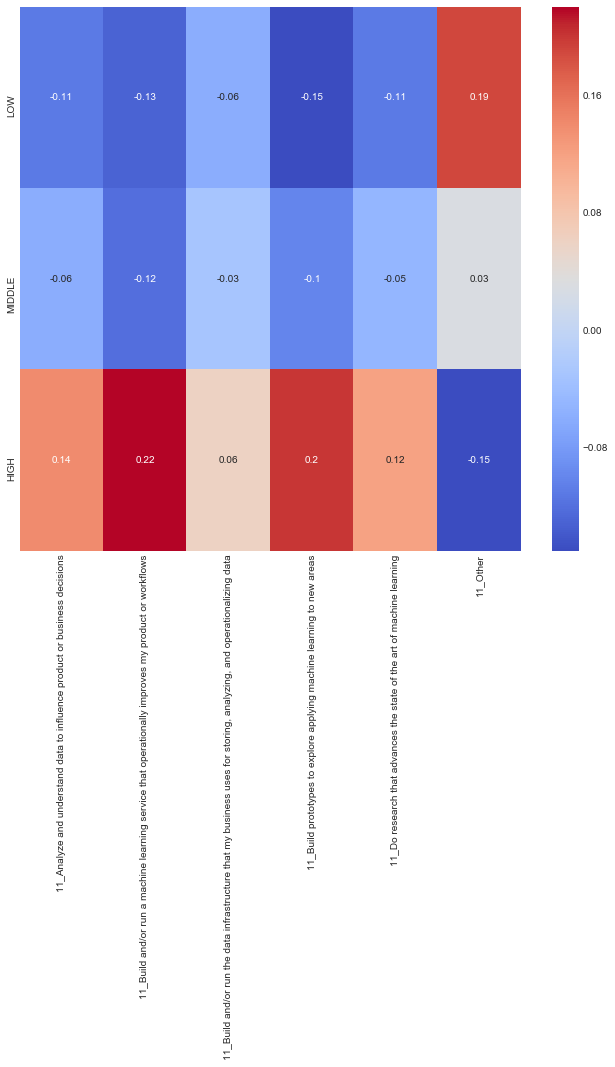

In [79]:
cor_mat=round(pd.concat([confdummy,q11],axis=1,keys=['r','q']).corr().loc['r','q'],2)
plt.figure(figsize=(10,10))
sns.heatmap(cor_mat,cmap='coolwarm',annot=True)

In [80]:
ndata=pd.concat([ndata,q11],axis=1)

## Q12
원래부터 숫자로 onehot encoding 되어있었음

In [81]:
q12=data[[t for t in data.columns if 'Q12' in t]]
q12=q12.iloc[:,1:]
q12=q12.astype(int) 
q12[q12!=-1]=1
q12[q12==-1]=0
q12.head()

,Q12_Part_1_TEXT,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT,Q12_OTHER_TEXT
1,1,0,0,0,0,0
2,0,0,0,1,0,0
4,0,1,0,0,0,0
6,1,0,0,0,0,0
7,0,0,0,1,0,0


In [82]:
q12.columns =['Basic statistical software (Microsoft Excel, Google Sheets, etc.)',
                             'Advanced statistical software (SPSS, SAS, etc.)',
                             'Business intelligence software (Salesforce, Tableau, Spotfire, etc.)',
                             'Local or hosted development environments (RStudio, JupyterLab, etc.)',
                             'Cloud-based data software & APIs (AWS, GCP, Azure, etc.)','Other']

In [83]:
q=q12.idxmax(axis=1)

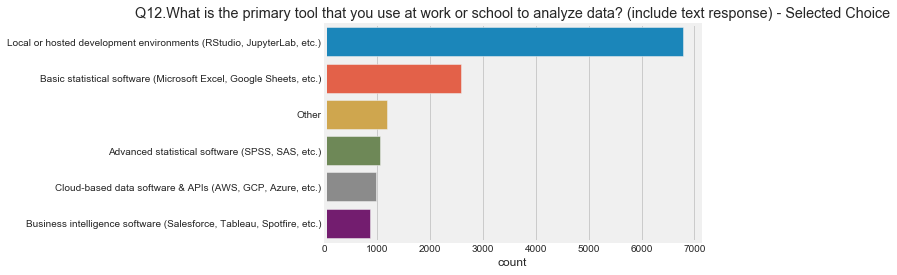

In [84]:
order=q.value_counts(ascending=False).index
sns.countplot(y=q, order=order)
# plt.xticks(rotation=60)
plt.title('Q12.' + qs.iloc[0,12+1])
plt.show()

In [85]:
len(q12[q12.iloc[:,1].isna()])

0

In [86]:
q12.columns=['12_'+ str(col) for col in q12.columns]
ndata=pd.concat([ndata,q12],axis=1)

## Q13

In [87]:
def plotnprocess(data,i,title):
    s='Q'+str(i)
    if s+'_OTHER_TEXT' in data.columns:
        data=data.drop([s+'_OTHER_TEXT'],axis=1)
    df=to_onehot(i)
    
    x=df.sum(axis=0)
    x=x.sort_values()
    plt.figure(figsize=(10,7))
    x.plot(kind='barh')
    plt.title(title)
    plt.show()
    
    df.columns=[str(i)+'_'+str(col) for col in df.columns]
    return df

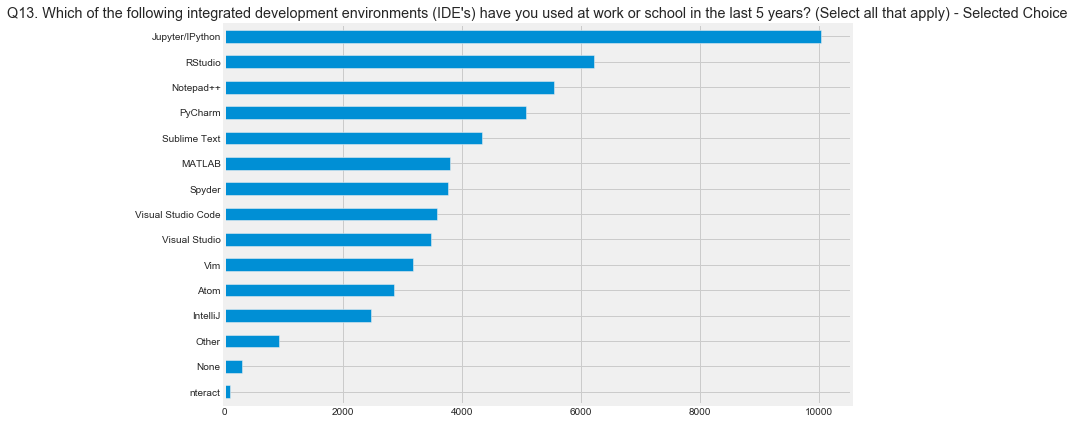

In [88]:
q13=plotnprocess(data,13,'Q13. '+qs.iloc[0,13+1])
ndata=pd.concat([ndata,q13],axis=1)

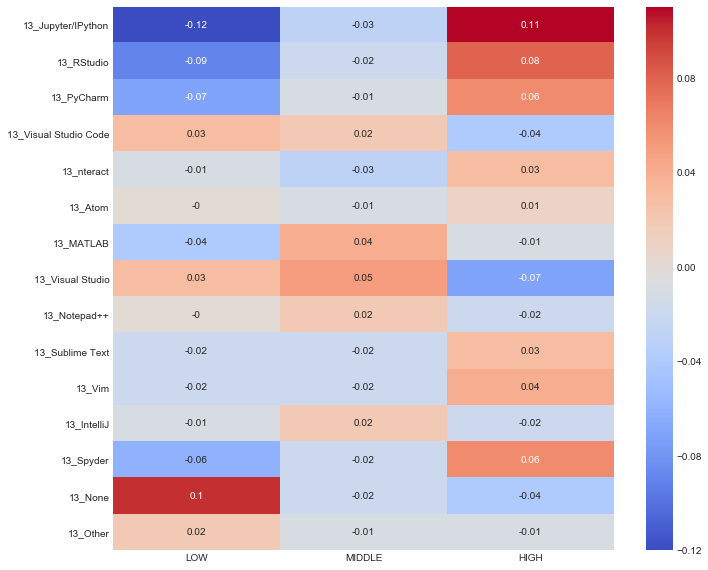

In [89]:
cor_mat=round(pd.concat([q13,confdummy],axis=1,keys=['r','q']).corr().loc['r','q'],2)
plt.figure(figsize=(10,10))
sns.heatmap(cor_mat,cmap='coolwarm',annot=True)

In [90]:
ndata.head()

,1_Female,1_Male,age,3_Africa,3_Asia,3_Europe,3_NorthAmerica,3_Oceania,3_SouthAmerica,4_Bachelor’s degree,...,13_Atom,13_MATLAB,13_Visual Studio,13_Notepad++,13_Sublime Text,13_Vim,13_IntelliJ,13_Spyder,13_None,13_Other
1,0,1,3,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,1,0,3,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,1,0,0,0,0,0,...,1,0,1,1,1,0,1,1,0,0


## Q14

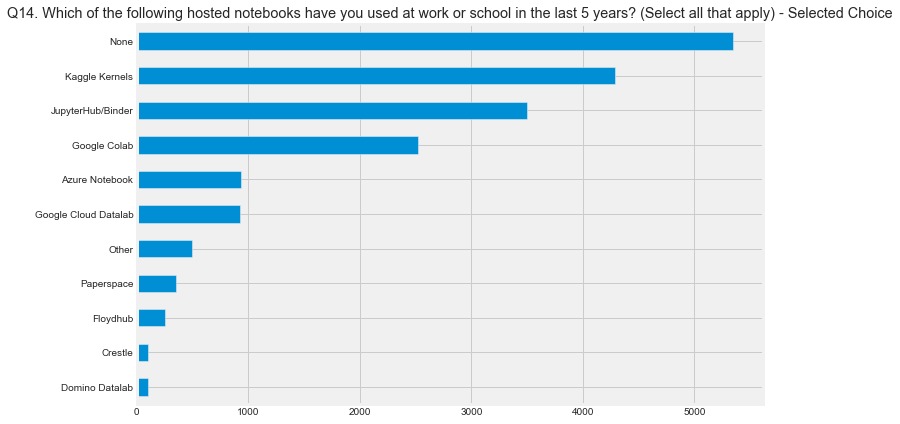

In [91]:
q14=plotnprocess(data,14,'Q14. '+qs.iloc[0,14+1])
ndata=pd.concat([ndata,q14],axis=1)

None의 의미 = 쓰지 않는다? or 이 중에 없다?

## Q15-Q16

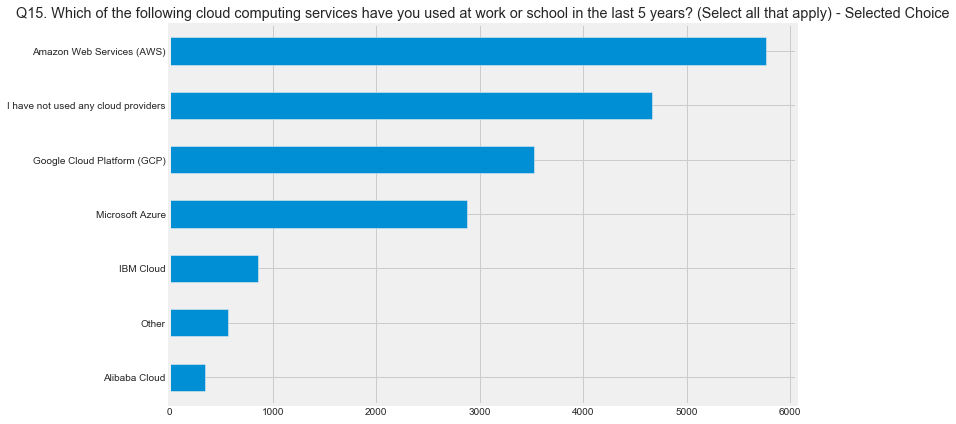

In [92]:
q15=plotnprocess(data,15,'Q15. '+qs.iloc[0,15+1])
ndata=pd.concat([ndata,q15],axis=1)

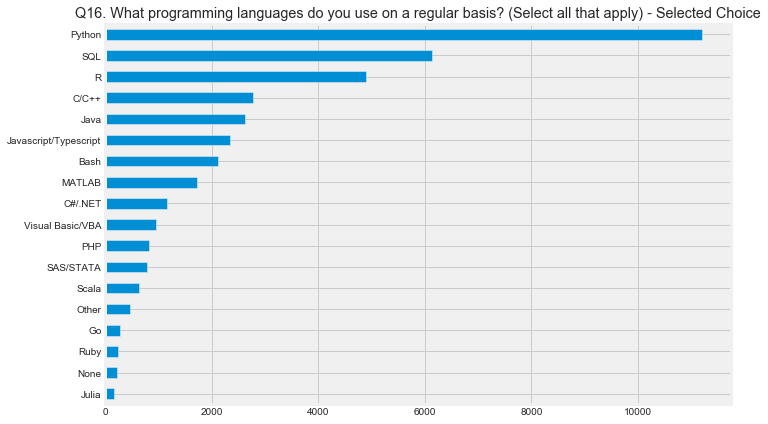

In [93]:
q16=plotnprocess(data,16,'Q16. '+qs.iloc[0,16+1])
ndata=pd.concat([ndata,q16],axis=1)

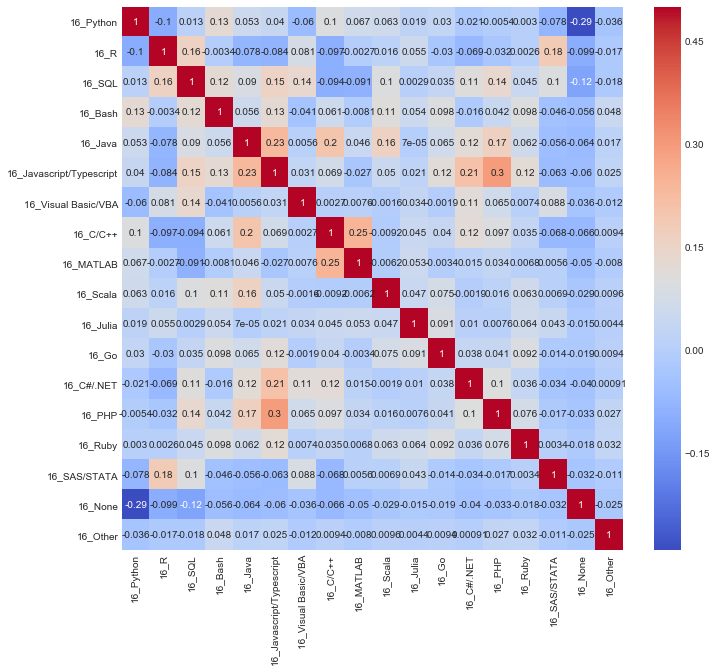

In [94]:
corr_matrix = q16.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr_matrix, vmax=0.5, cmap='coolwarm', annot=True)

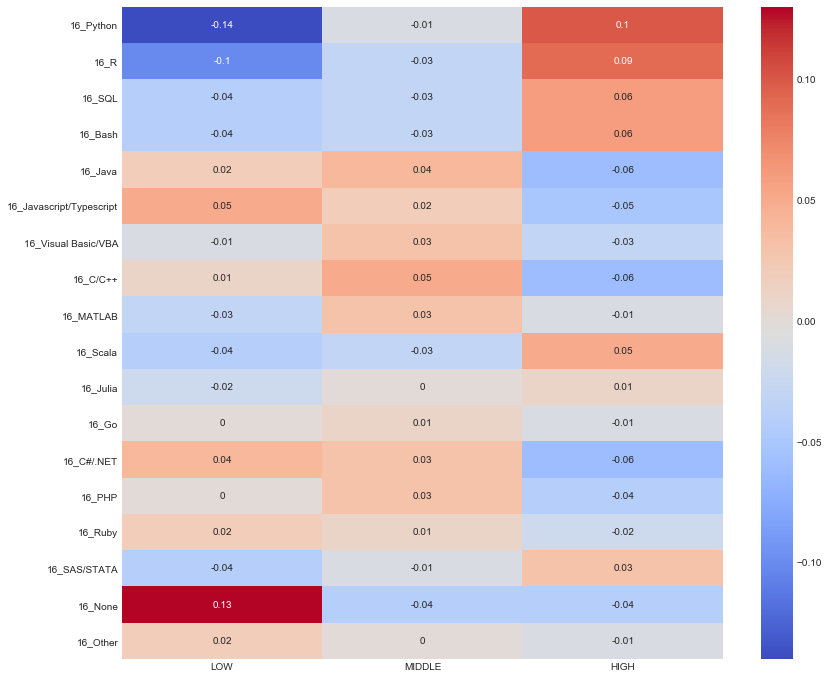

In [95]:
cor_mat=round(pd.concat([q16,confdummy],axis=1,keys=['r','q']).corr().loc['r','q'],2)
plt.figure(figsize=(12,12))
sns.heatmap(cor_mat,cmap='coolwarm',annot=True)

## Q17(제외)

## Q18(제외)

## Q19

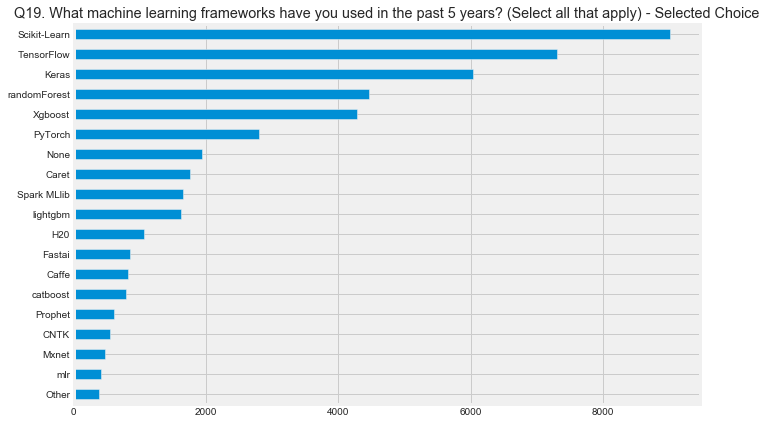

In [96]:
q19=plotnprocess(data,19,'Q19. '+qs.iloc[0,19+1])
ndata=pd.concat([ndata,q19],axis=1)

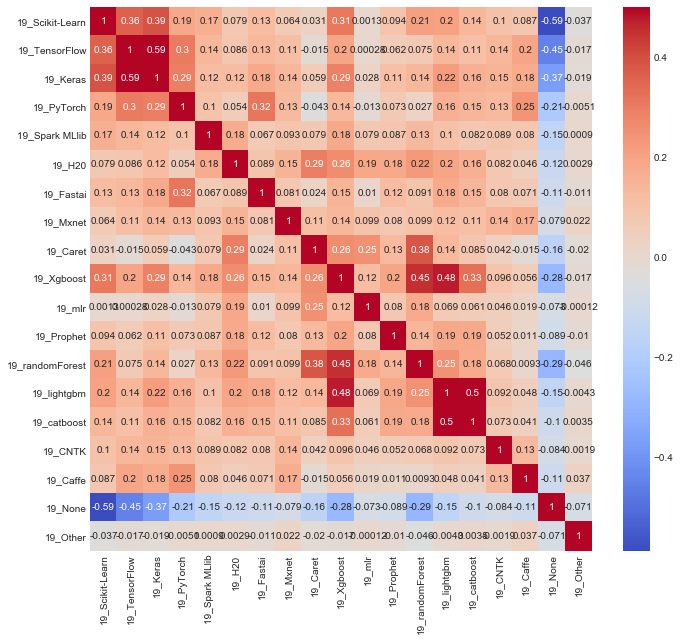

In [97]:
corr_matrix = q19.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr_matrix, vmax=0.5, cmap='coolwarm', annot=True)

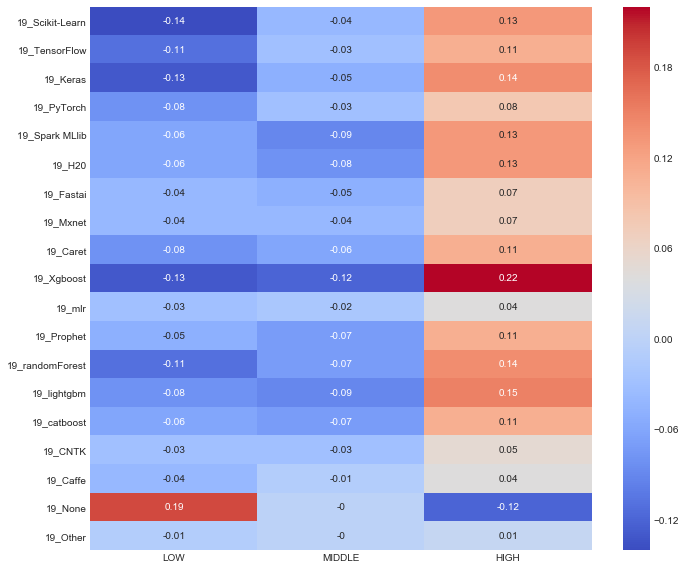

In [98]:
cor_mat=round(pd.concat([q19,confdummy],axis=1,keys=['r','q']).corr().loc['r','q'],2)
plt.figure(figsize=(10,10))
sns.heatmap(cor_mat,cmap='coolwarm',annot=True)

## Q20(제외)

## Q21.

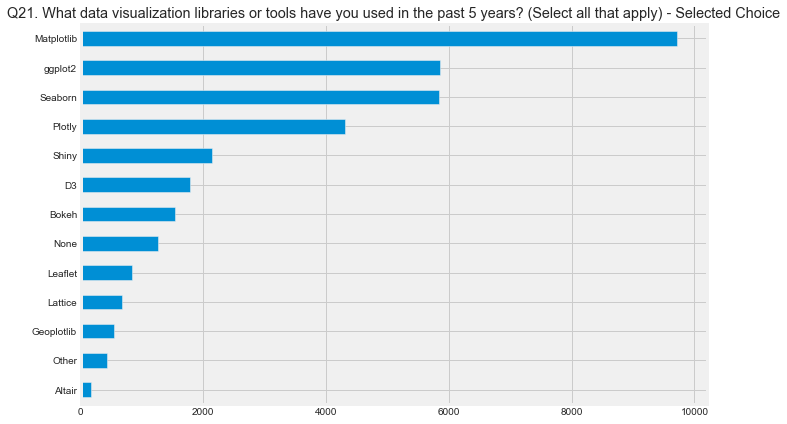

In [99]:
q21=plotnprocess(data,21,'Q21. '+qs.iloc[0,21+1])
ndata=pd.concat([ndata,q21],axis=1)

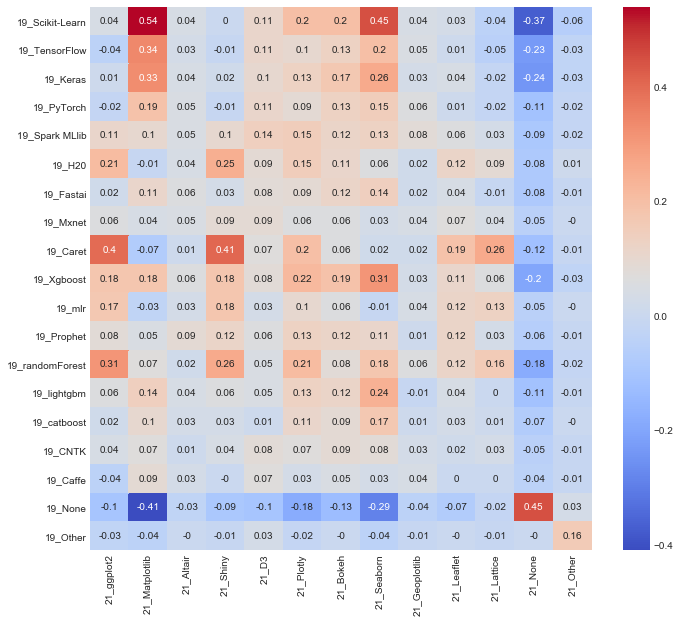

In [100]:
cor_mat=round(pd.concat([q19,q21],axis=1,keys=['r','q']).corr().loc['r','q'],2)
plt.figure(figsize=(10,10))
sns.heatmap(cor_mat,cmap='coolwarm',annot=True)

## Q22(제외)

## Q23-Q26
get_dummies

In [101]:
data.Q23.unique()

array(['1% to 25% of my time', '75% to 99% of my time',
       '25% to 49% of my time', '50% to 74% of my time',
       '100% of my time', '0% of my time'], dtype=object)

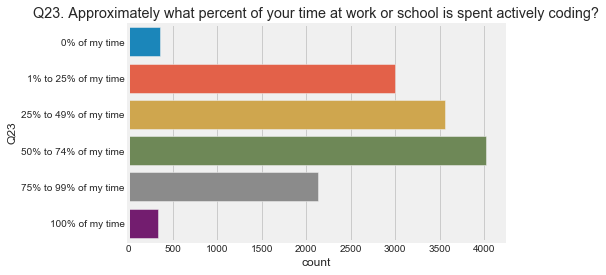

In [102]:
sns.countplot(y=data.Q23,order=['0% of my time', '1% to 25% of my time', '25% to 49% of my time','50% to 74% of my time', '75% to 99% of my time','100% of my time'])
plt.title('Q23. '+qs.iloc[0,23+1])
plt.show()

In [103]:
q23=pd.get_dummies(data.Q23)
q23.columns=['23_'+str(col) for col in q23.columns]
ndata=pd.concat([ndata,q23],axis=1)

In [104]:
data.Q24.unique()

array(['I have never written code but I want to learn', '5-10 years',
       '< 1 year', '1-2 years', '3-5 years', '10-20 years', '30-40 years',
       '20-30 years',
       'I have never written code and I do not want to learn',
       '40+ years'], dtype=object)

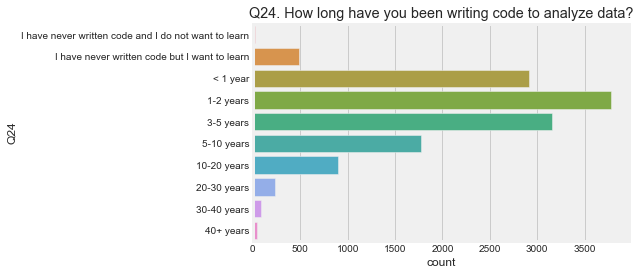

In [105]:
sns.countplot(y=data.Q24,order=['I have never written code and I do not want to learn','I have never written code but I want to learn','< 1 year','1-2 years','3-5 years',   '5-10 years',
       '10-20 years', '20-30 years','30-40 years','40+ years'])
plt.title('Q24. '+qs.iloc[0,24+1])
plt.show()

In [106]:
lst=['I have never written code and I do not want to learn','I have never written code but I want to learn','< 1 year','1-2 years','3-5 years',   '5-10 years',
       '10-20 years', '20-30 years','30-40 years','40+ years']

In [107]:
q24=pd.get_dummies(data.Q24)
q24.columns=['24_'+str(col) for col in q24.columns]
q24=q24.reindex(columns=list(map(lambda x: '24_'+x,lst)))
ndata=pd.concat([ndata,q24],axis=1)

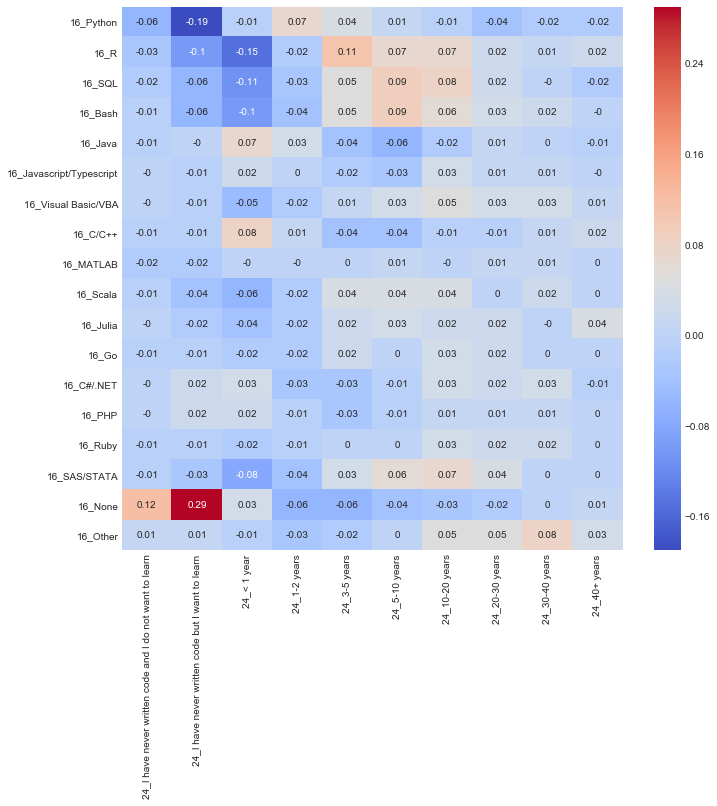

In [108]:
cor_mat=round(pd.concat([q16,q24],axis=1,keys=['r','q']).corr().loc['r','q'],2)
plt.figure(figsize=(10,10))
sns.heatmap(cor_mat,cmap='coolwarm',annot=True)

요즘 강세는 python!

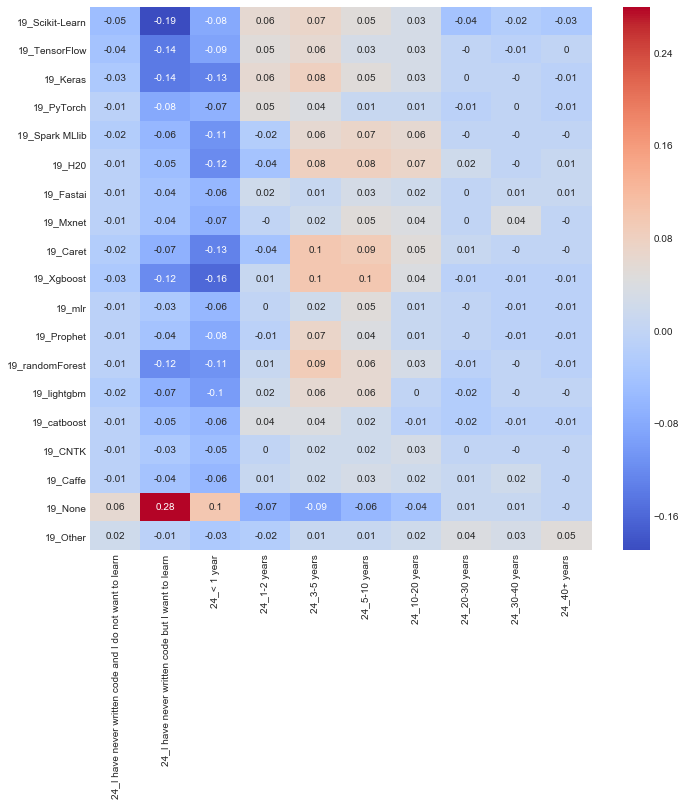

In [109]:
cor_mat=round(pd.concat([q19,q24],axis=1,keys=['r','q']).corr().loc['r','q'],2)
plt.figure(figsize=(10,10))
sns.heatmap(cor_mat,cmap='coolwarm',annot=True)

최근경력에 pytorch↑  
3-5,5-10 에서 caret, prophet,spark,h20,lightgbm 많아짐

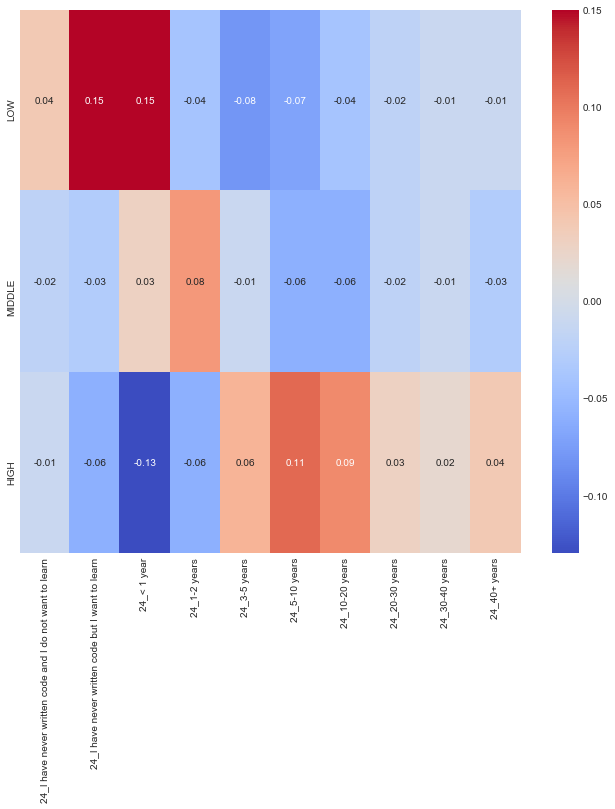

In [110]:
cor_mat=round(pd.concat([confdummy,q24],axis=1,keys=['r','q']).corr().loc['r','q'],2)
plt.figure(figsize=(10,10))
sns.heatmap(cor_mat,cmap='coolwarm',annot=True)

In [111]:
lst=['I have never studied machine learning and I do not plan to','I have never studied machine learning but plan to learn in the future',
       '< 1 year',  '1-2 years','2-3 years','3-4 years','4-5 years',  '5-10 years','10-15 years','20+ years' ]

In [112]:
data.Q25.unique()

array(['I have never studied machine learning but plan to learn in the future',
       '< 1 year', '2-3 years', '5-10 years', '1-2 years', '3-4 years',
       '4-5 years',
       'I have never studied machine learning and I do not plan to',
       '10-15 years', '20+ years'], dtype=object)

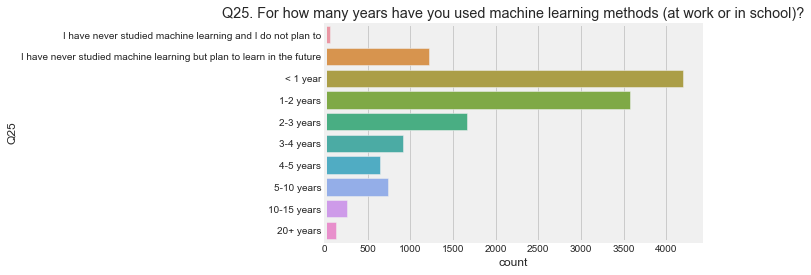

In [113]:
sns.countplot(y=data.Q25,order=lst)
plt.title('Q25. '+qs.iloc[0,25+1])
plt.show()
q25=pd.get_dummies(data.Q25)
q25.columns=['25_'+str(col) for col in q25.columns]
ndata=pd.concat([ndata,q25],axis=1)

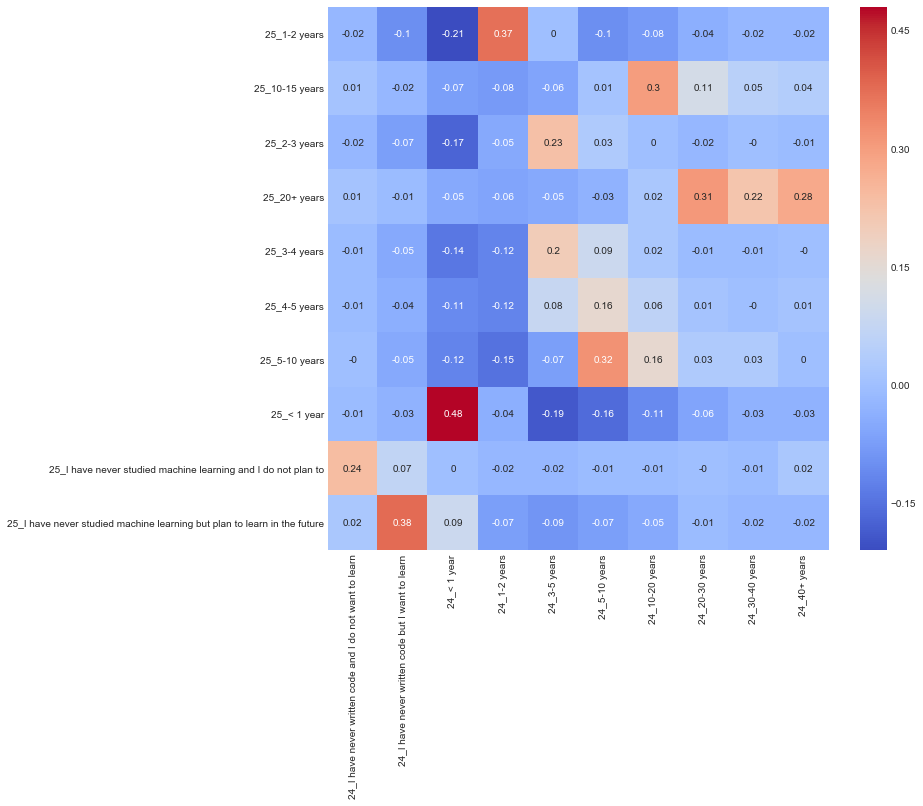

In [114]:
cor_mat=round(pd.concat([q25,q24],axis=1,keys=['r','q']).corr().loc['r','q'],2)
plt.figure(figsize=(10,10))
sns.heatmap(cor_mat,cmap='coolwarm',annot=True)

## Q27-Q31, Q33(제외), Q36, Q38, Q42, Q44, Q45, Q47, Q49, Q50

In [115]:
print(data['Q38_Part_19'].unique())
print(data['Q38_Part_20'].unique())

[nan]
[nan]


In [116]:
data=data.drop(['Q38_Part_19'],axis=1)
data=data.drop(['Q38_Part_20'],axis=1)

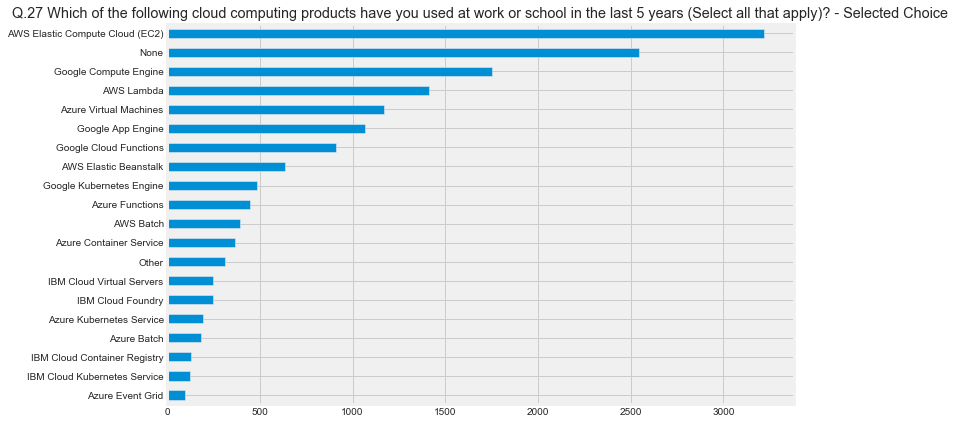

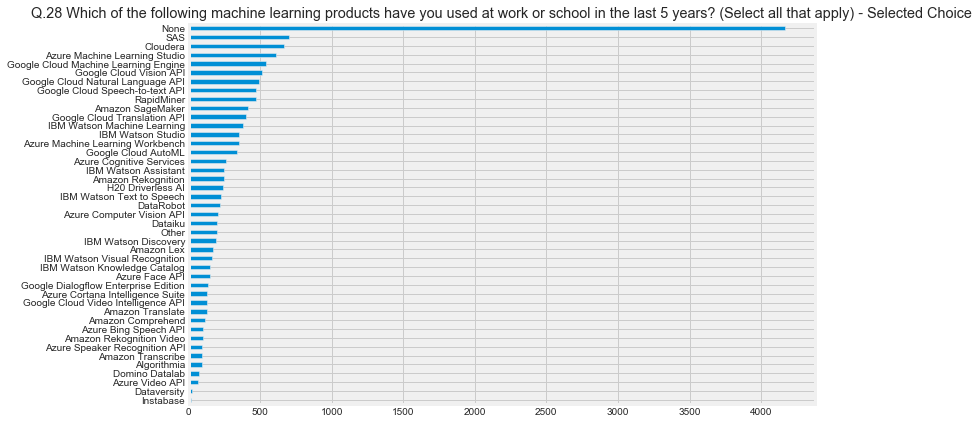

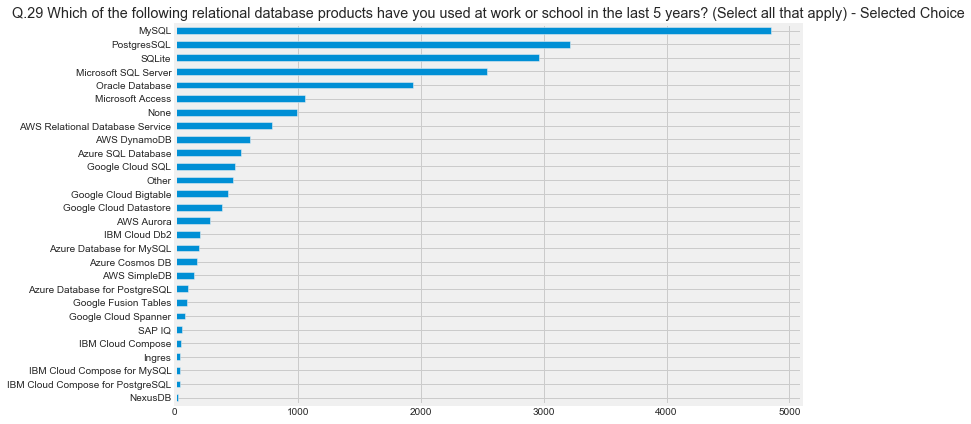

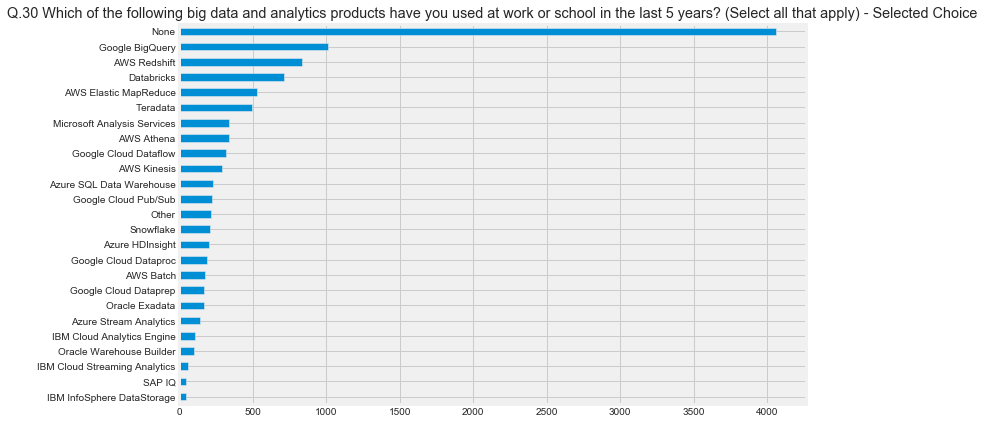

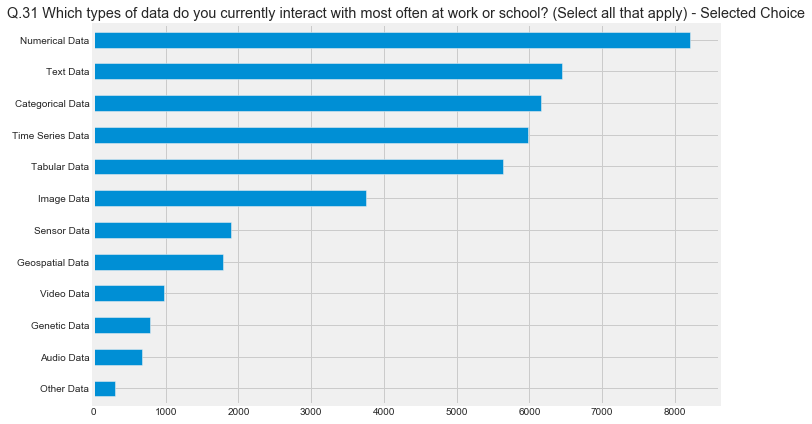

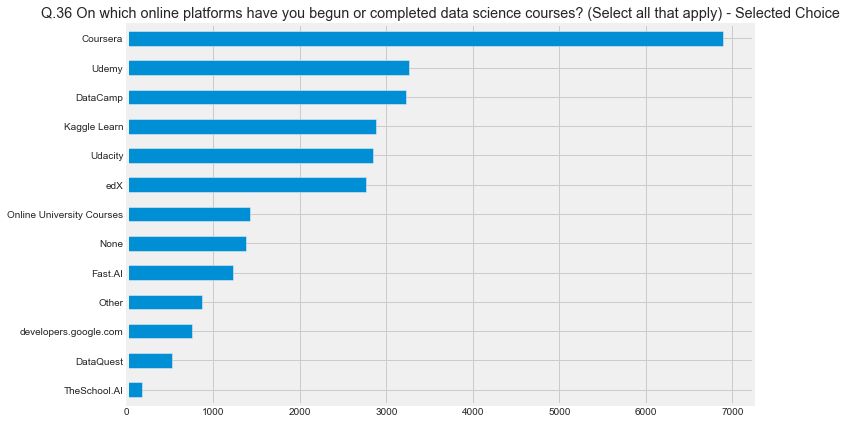

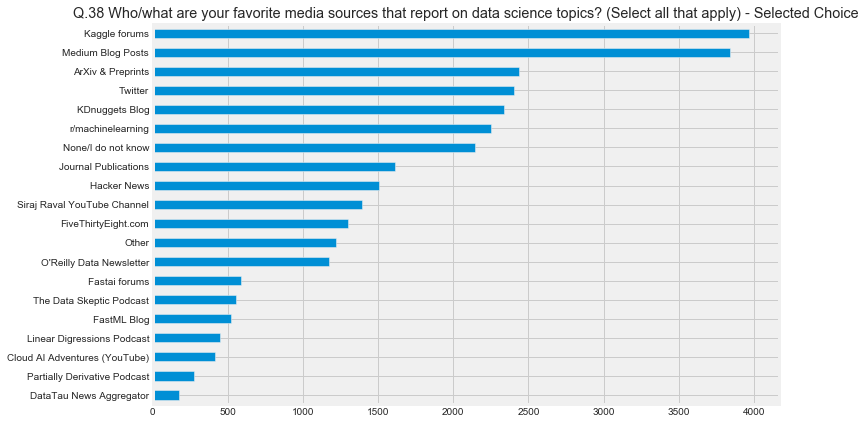

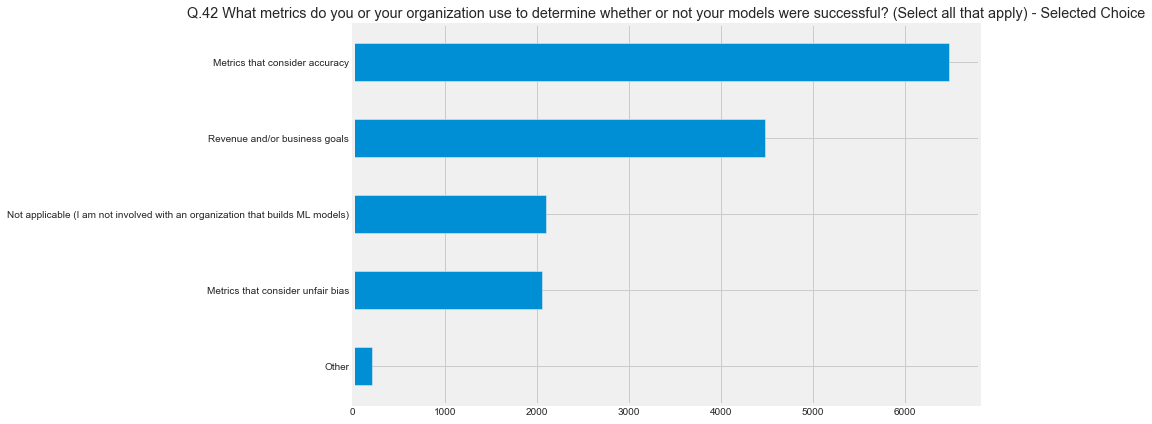

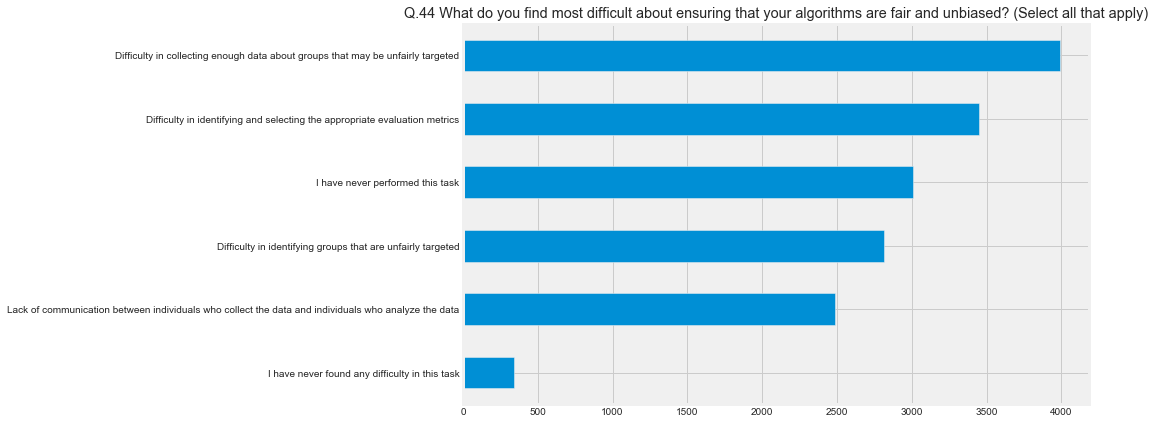

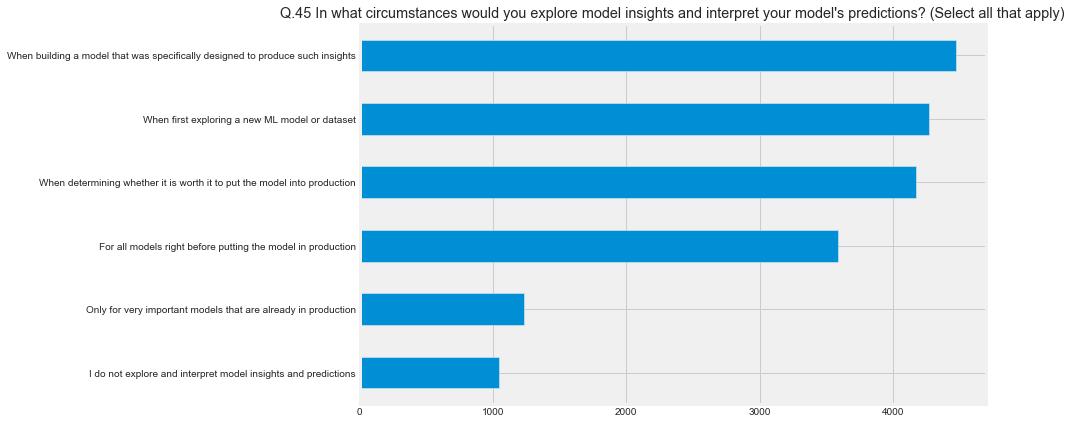

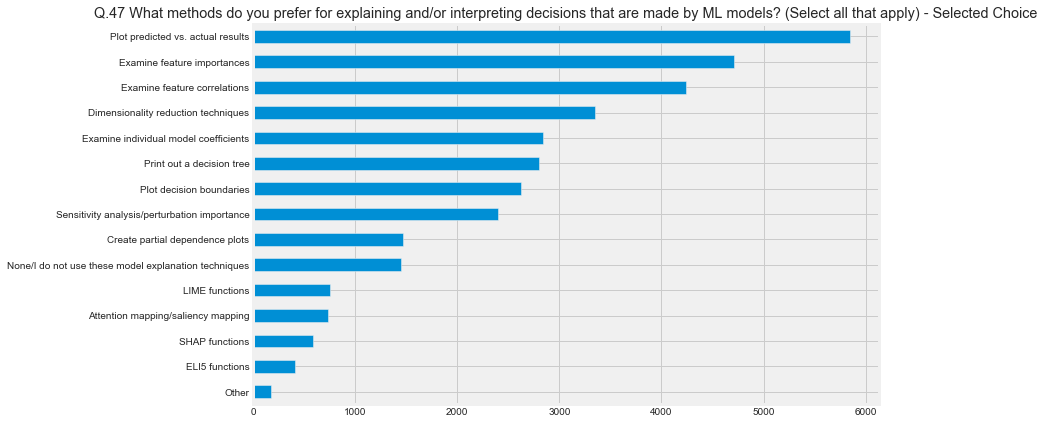

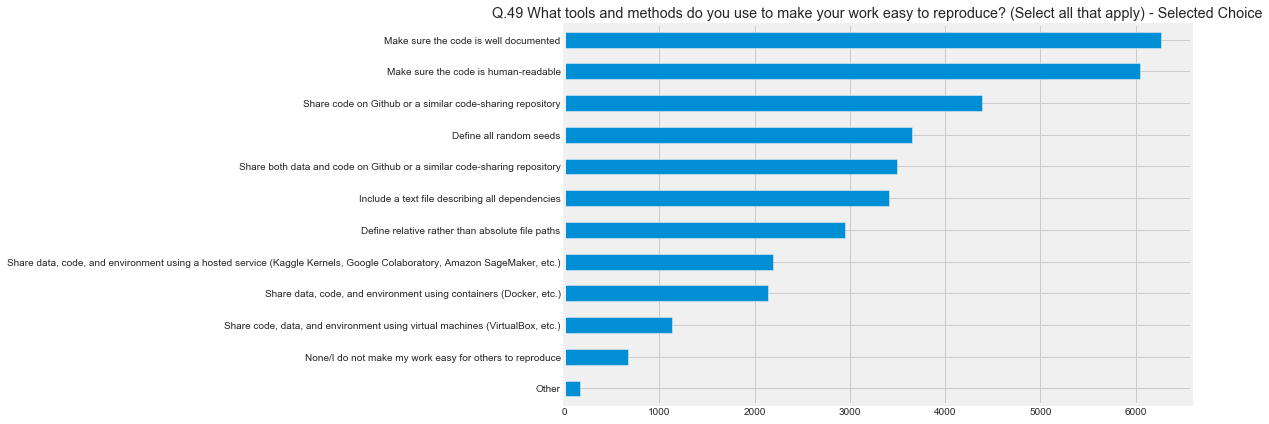

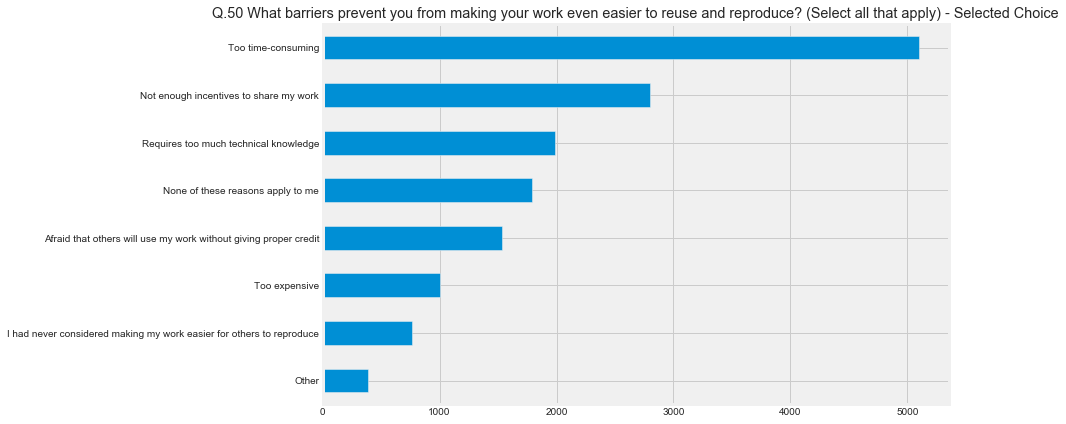

In [117]:
#Q36, Q38, Q42, Q44, Q45, Q47, Q49, Q50
for i in [27,28,29,30,31,36,38,42,44,45,47,49,50]:  
    df=plotnprocess(data,i,'Q.'+str(i)+' '+qs.iloc[0,i+1])
    ndata=pd.concat([ndata,df],axis=1)

In [118]:
strr = ['28_Google','28_IBM','28_Azure','28_Amazon']
for s in strr:
    cols = [i for i in ndata.columns if s in i]
    n = ndata[cols[0]]
    for i in range(1,len(cols)):
        n = n|ndata[cols[i]]
    n = pd.Series(n)
    n.name= s
    ndata = ndata.drop(cols,axis=1)
    ndata = pd.concat([ndata,n],axis=1)
ndata.head()

,1_Female,1_Male,age,3_Africa,3_Asia,3_Europe,3_NorthAmerica,3_Oceania,3_SouthAmerica,4_Bachelor’s degree,...,50_Requires too much technical knowledge,50_Afraid that others will use my work without giving proper credit,50_Not enough incentives to share my work,50_I had never considered making my work easier for others to reproduce,50_None of these reasons apply to me,50_Other,28_Google,28_IBM,28_Azure,28_Amazon
1,0,1,3,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,3,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
6,0,1,4,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
7,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [119]:
strr = ['29_Google','29_IBM','29_Azure']
for s in strr:
    cols = [i for i in ndata.columns if s in i]
    n = ndata[cols[0]]
    for i in range(1,len(cols)):
        n = n|ndata[cols[i]]
    n = pd.Series(n)
    n.name= s
    ndata = ndata.drop(cols,axis=1)
    ndata = pd.concat([ndata,n],axis=1)
ndata.head()

,1_Female,1_Male,age,3_Africa,3_Asia,3_Europe,3_NorthAmerica,3_Oceania,3_SouthAmerica,4_Bachelor’s degree,...,50_I had never considered making my work easier for others to reproduce,50_None of these reasons apply to me,50_Other,28_Google,28_IBM,28_Azure,28_Amazon,29_Google,29_IBM,29_Azure
1,0,1,3,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,3,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
6,0,1,4,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
7,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
cols = [i for i in ndata.columns if '29_AWS' in i]
n = ndata[cols[0]]
for i in range(1,len(cols)):
    n = n|ndata[cols[i]]
n = pd.Series(n)
n.name= '29_AWS'
ndata = ndata.drop(cols,axis=1)
ndata = pd.concat([ndata,n],axis=1)
ndata.head()

,1_Female,1_Male,age,3_Africa,3_Asia,3_Europe,3_NorthAmerica,3_Oceania,3_SouthAmerica,4_Bachelor’s degree,...,50_None of these reasons apply to me,50_Other,28_Google,28_IBM,28_Azure,28_Amazon,29_Google,29_IBM,29_Azure,29_AWS
1,0,1,3,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,3,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
6,0,1,4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
cols = ['29_SQLite','29_PostgresSQL','29_MySQL']
n = ndata[cols[0]]
for i in range(1,len(cols)):
    n = n|ndata[cols[i]]
n = pd.Series(n)
n.name= '29_SQL'
ndata = ndata.drop(cols,axis=1)
ndata = pd.concat([ndata,n],axis=1)
ndata.head()

,1_Female,1_Male,age,3_Africa,3_Asia,3_Europe,3_NorthAmerica,3_Oceania,3_SouthAmerica,4_Bachelor’s degree,...,50_Other,28_Google,28_IBM,28_Azure,28_Amazon,29_Google,29_IBM,29_Azure,29_AWS,29_SQL
1,0,1,3,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,3,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
6,0,1,4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [122]:
strr = ['30_Google','30_IBM','30_Azure','30_AWS','30_Oracle']
for s in strr:
    cols = [i for i in ndata.columns if s in i]
    n = ndata[cols[0]]
    for i in range(1,len(cols)):
        n = n|ndata[cols[i]]
    n = pd.Series(n)
    n.name= s
    ndata = ndata.drop(cols,axis=1)
    ndata = pd.concat([ndata,n],axis=1)
ndata.head()

,1_Female,1_Male,age,3_Africa,3_Asia,3_Europe,3_NorthAmerica,3_Oceania,3_SouthAmerica,4_Bachelor’s degree,...,29_Google,29_IBM,29_Azure,29_AWS,29_SQL,30_Google,30_IBM,30_Azure,30_AWS,30_Oracle
1,0,1,3,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,3,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
6,0,1,4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Q32

In [123]:
len(data.Q32[data.Q32.isna()]) #NA값 - currently not working on something - 해당 column 제외하는게 나을지

3102

In [124]:
data.Q32.unique()

array([nan, 'Time Series Data', 'Numerical Data', 'Image Data',
       'Tabular Data', 'Sensor Data', 'Categorical Data', 'Text Data',
       'Genetic Data', 'Geospatial Data', 'Audio Data', 'Video Data',
       'Other Data'], dtype=object)

In [125]:
data.Q32[data.Q32.isna()] = 'None' #None으로 대체

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


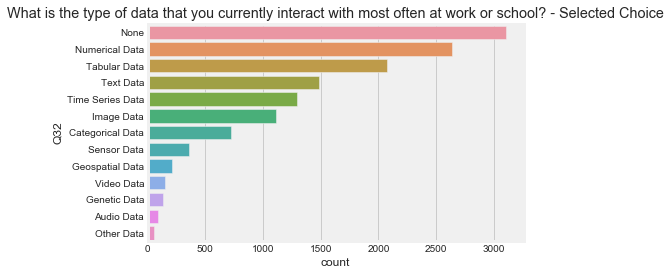

In [126]:
order=data.Q32.value_counts().index
sns.countplot(y=data.Q32,order=order)
plt.title(qs.iloc[0,32+1])
plt.show()

In [127]:
q32=pd.get_dummies(data.Q32) 
q32.columns=['32_'+str(col) for col in q32.columns]
ndata = pd.concat([ndata,q32],axis=1)

## Q34

In [128]:
len(data.Q34_Part_1[data.Q34_Part_1.isna()]) #NA값 - 제외하는게 좋을듯

1641

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


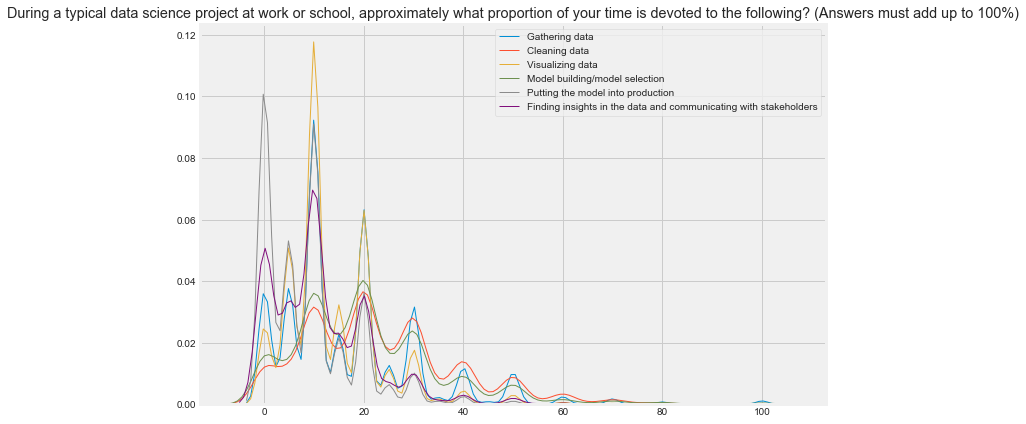

In [129]:
plt.figure(figsize=(10,7))
sns.kdeplot(data.Q34_Part_1[~data.Q34_Part_1.isna()],label='Gathering data',linewidth=1)
sns.kdeplot(data.Q34_Part_2[~data.Q34_Part_2.isna()],label='Cleaning data',linewidth=1)
sns.kdeplot(data.Q34_Part_3[~data.Q34_Part_3.isna()],label='Visualizing data',linewidth=1)
sns.kdeplot(data.Q34_Part_4[~data.Q34_Part_4.isna()],label='Model building/model selection',linewidth=1)
sns.kdeplot(data.Q34_Part_5[~data.Q34_Part_5.isna()],label='Putting the model into production',linewidth=1)
sns.kdeplot(data.Q34_Part_6[~data.Q34_Part_6.isna()],label='Finding insights in the data and communicating with stakeholders',linewidth=1)
plt.title(qs.iloc[0,34+1])
plt.show()

#### Data scaling 진행(100으로 나눠줌)

In [130]:
q34=data[[t for t in data.columns if 'Q34_' in t]]
q34=q34.drop(['Q34_OTHER_TEXT'],axis=1)

In [131]:
for i in range(q34.shape[1]):
    tmp=pd.to_numeric(q34.iloc[:,i])/100
    ndata=pd.concat([ndata,tmp],axis=1)

In [132]:
ndata.head()

,1_Female,1_Male,age,3_Africa,3_Asia,3_Europe,3_NorthAmerica,3_Oceania,3_SouthAmerica,4_Bachelor’s degree,...,32_Tabular Data,32_Text Data,32_Time Series Data,32_Video Data,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6
1,0,1,3,0,1,0,0,0,0,1,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,3,0,0,0,1,0,0,0,...,0,0,1,0,0.02,0.03,0.2,0.5,0.20,0.00
4,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0.10,0.10,0.2,0.1,0.20,0.23
6,0,1,4,0,0,0,0,0,1,0,...,0,0,0,0,0.00,0.30,0.5,0.0,0.00,0.20
7,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0.20,0.30,0.2,0.2,0.05,0.05


## Q35

In [133]:
len(data.Q35_Part_1[data.Q35_Part_1.isna()]) #NA값 마찬가지로 제외하는게 좋을듯

1762

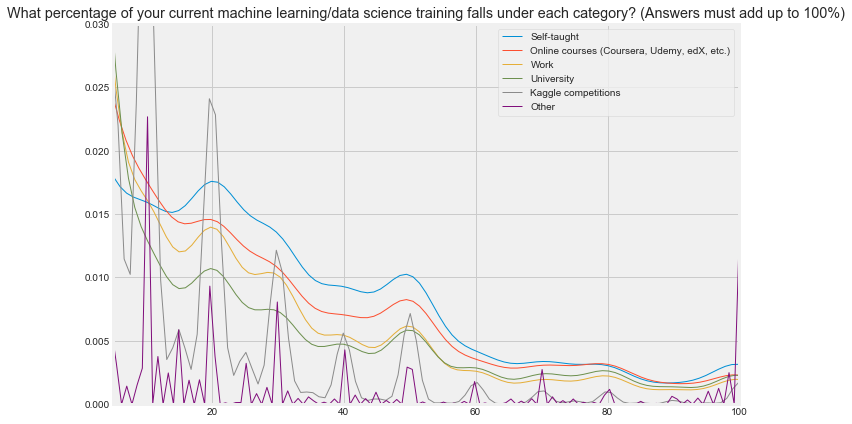

In [134]:
plt.figure(figsize=(10,7))
sns.kdeplot(data.Q35_Part_1[~data.Q35_Part_1.isna()],label='Self-taught',linewidth=1)
sns.kdeplot(data.Q35_Part_2[~data.Q35_Part_2.isna()],label='Online courses (Coursera, Udemy, edX, etc.)',linewidth=1)
sns.kdeplot(data.Q35_Part_3[~data.Q35_Part_3.isna()],label='Work',linewidth=1)
sns.kdeplot(data.Q35_Part_4[~data.Q35_Part_4.isna()],label='University',linewidth=1)
sns.kdeplot(data.Q35_Part_5[~data.Q35_Part_5.isna()],label='Kaggle competitions',linewidth=1)
sns.kdeplot(data.Q35_Part_6[~data.Q35_Part_6.isna()],label='Other',linewidth=1)
plt.xlim(5,100)
plt.ylim(0,0.03)
plt.title(qs.iloc[0,35+1])
plt.show()

In [135]:
q35=data[[t for t in data.columns if 'Q35_' in t]]
q35=q35.drop(['Q35_OTHER_TEXT'],axis=1)
q35

,Q35_Part_1,Q35_Part_2,Q35_Part_3,Q35_Part_4,Q35_Part_5,Q35_Part_6
1,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0,100,0,0
4,20,40,20,20,0,0
6,50,20,30,0,0,0
7,75,5,20,0,0,0
...,...,...,...,...,...,...
18471,0,100,0,0,0,0
18472,0,0,0,0,100,0
18473,NaN,NaN,NaN,NaN,NaN,NaN
18475,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
for i in range(q35.shape[1]):
    tmp=pd.to_numeric(q35.iloc[:,i])/100
    ndata=pd.concat([ndata,tmp],axis=1)

In [137]:
ndata.head()

,1_Female,1_Male,age,3_Africa,3_Asia,3_Europe,3_NorthAmerica,3_Oceania,3_SouthAmerica,4_Bachelor’s degree,...,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q35_Part_1,Q35_Part_2,Q35_Part_3,Q35_Part_4,Q35_Part_5,Q35_Part_6
1,0,1,3,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,3,0,0,0,1,0,0,0,...,0.2,0.5,0.20,0.00,0.00,0.00,0.0,1.0,0.0,0.0
4,0,1,1,0,1,0,0,0,0,0,...,0.2,0.1,0.20,0.23,0.20,0.40,0.2,0.2,0.0,0.0
6,0,1,4,0,0,0,0,0,1,0,...,0.5,0.0,0.00,0.20,0.50,0.20,0.3,0.0,0.0,0.0
7,0,1,0,0,1,0,0,0,0,0,...,0.2,0.2,0.05,0.05,0.75,0.05,0.2,0.0,0.0,0.0


## Q37
On which online platform have you spent the most amount of time? 

In [138]:
len(data.Q37[data.Q37.isna()]) #So many NA값 - 해당 column 아예 제외

6117

## Q39,Q40,Q41, Q43, Q46, Q48

In [139]:
data.Q39_Part_1.unique()

array(['Slightly worse', 'Slightly better', 'Much worse',
       'Neither better nor worse', 'Much better',
       'No opinion; I do not know', nan], dtype=object)

In [140]:
len(data.Q39_Part_1[data.Q39_Part_1.isna()]) #NA값 제외

1676

In [141]:
#Numeric encoding
encode={'No opinion; I do not know':0, 'Much worse':1,'Slightly worse':2, 'Neither better nor worse':3,
        'Slightly better':4,'Much better':5}
tmp=data.Q39_Part_1.copy()
tmp=tmp.replace(encode)

In [142]:
ndata=pd.concat([ndata,tmp],axis=1)

In [143]:
data.Q39_Part_2.unique()

array(['No opinion; I do not know', 'Slightly better', 'Much better',
       'Neither better nor worse', 'Much worse', 'Slightly worse', nan],
      dtype=object)

In [144]:
len(data.Q39_Part_2[data.Q39_Part_2.isna()])

1676

In [145]:
#Numeric encoding
tmp=data.Q39_Part_2.copy()
tmp=tmp.replace(encode)
ndata=pd.concat([ndata,tmp],axis=1)

In [146]:
data.Q40.unique()

array(['Independent projects are equally important as academic achievements',
       'Independent projects are slightly more important than academic achievements',
       'Independent projects are much more important than academic achievements',
       'Independent projects are much less important than academic achievements',
       'Independent projects are slightly less important than academic achievements',
       'No opinion; I do not know', nan], dtype=object)

In [147]:
len(data.Q40[data.Q40.isna()]) #NA값삭제

1740

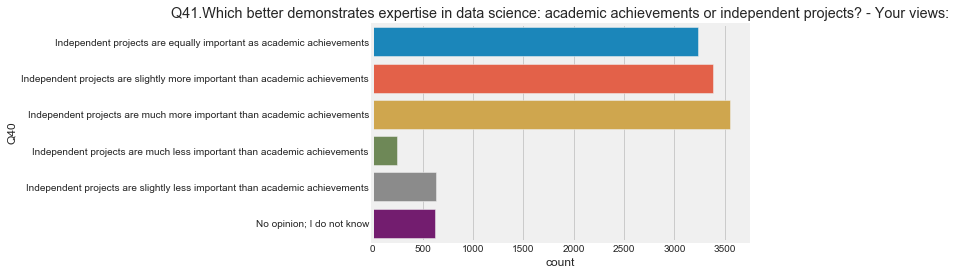

In [148]:
sns.countplot(y=data.Q40[~data.Q40.isna()])
plt.title('Q41.'+ qs.iloc[0,40+1])
plt.show()

In [149]:
#Numeric encoding
encode={'No opinion; I do not know':0, 'Independent projects are much less important than academic achievements':1,
        'Independent projects are slightly less important than academic achievements':2,
        'Independent projects are equally important as academic achievements':3, 
        'Independent projects are slightly more important than academic achievements':4,
        'Independent projects are much more important than academic achievements':5}
tmp=data.Q40.copy()
tmp=tmp.replace(encode)

In [150]:
ndata = pd.concat([ndata,tmp],axis=1)

In [151]:
data.Q41_Part_1.unique()

array([nan, 'Very important', 'Not at all important',
       'Slightly important', 'No opinion; I do not know'], dtype=object)

In [152]:
len(data.Q41_Part_1[data.Q41_Part_1.isna()])

2329

In [153]:
encode = {'Very important':3, 'Slightly important':2,
       'Not at all important':1, 'No opinion; I do not know':0}
tmp = data[[i for i in data.columns if 'Q41_' in i]]
tmp = tmp.replace(encode)

In [154]:
ndata = pd.concat([ndata,tmp],axis=1)

In [155]:
data.Q43.unique()

array([nan, '0-10', '20-30', '0', '10-20', '30-40', '40-50', '90-100',
       '70-80', '50-60', '60-70', '80-90'], dtype=object)

In [156]:
len(data.Q43[data.Q43.isna()]) #NA값 삭제..타격이 클듯

3552

In [157]:
#numeric encoding
encode = {'0-10':1, '20-30':3, '0':0, '10-20':2, '30-40':4, '60-70':7, '40-50':5,
       '90-100':10, '70-80':8, '50-60':6, '80-90':9}
tmp = data.Q43.copy()
tmp = tmp.replace(encode)

In [158]:
ndata = pd.concat([ndata,tmp],axis=1)

In [159]:
data.Q46.unique()

array([nan, '10-20', '20-30', '0', '50-60', '40-50', '90-100', '80-90',
       '0-10', '30-40', '70-80', '60-70'], dtype=object)

In [160]:
#numeric encoding
encode = {'0-10':1, '20-30':3, '0':0, '10-20':2, '30-40':4, '60-70':7, '40-50':5,
       '90-100':10, '70-80':8, '50-60':6, '80-90':9}
tmp = data.Q46.copy()
tmp = tmp.replace(encode)

In [161]:
ndata = pd.concat([ndata,tmp],axis=1)

In [162]:
data.Q48.unique()

array([nan,
       'I am confident that I can explain the outputs of most if not all ML models',
       'I am confident that I can understand and explain the outputs of many but not all ML models',
       'I do not know; I have no opinion on the matter',
       'I view ML models as "black boxes" but I am confident that experts are able to explain model outputs',
       'Yes, most ML models are "black boxes"'], dtype=object)

In [163]:
#numeric encoding
encode = {'I am confident that I can explain the outputs of most if not all ML models':1,
       'Yes, most ML models are "black boxes"':4,
       'I am confident that I can understand and explain the outputs of many but not all ML models':2,
       'I view ML models as "black boxes" but I am confident that experts are able to explain model outputs':3,
       'I do not know; I have no opinion on the matter':0}
tmp = data.Q48.copy()
tmp = tmp.replace(encode)

In [164]:
ndata = pd.concat([ndata,tmp],axis=1)

In [165]:
confle=pd.Series(conf)
confle=conf.rename('Confidence')
confle

0        1
1        0
2        2
3        1
4        1
        ..
18475    1
18476    2
18477    2
18478    1
18479    2
Name: Confidence, Length: 18480, dtype: int64

In [166]:
ndata.shape

(13406, 366)

In [167]:
for c in ndata:
    if len(ndata[ndata[c].isna()])>0:
        print(c,len(ndata[c][ndata[c].isna()]))
        ndata=ndata[~ndata[c].isna()]#NA값 모두 제거

salary 782
Q34_Part_1 1528
Q35_Part_1 115
Q39_Part_1 361
Q40 52
Q41_Part_1 121
Q43 1135
Q46 393
Q48 142


In [168]:
# 47의 이상한 값 제거
print([col for col in ndata.columns if '47_' in col])
len(ndata['47_Visualising and interpreting predicted vs. actual'][ndata['47_Visualising and interpreting predicted vs. actual']==1])

['47_Examine individual model coefficients', '47_Examine feature correlations', '47_Examine feature importances', '47_Plot decision boundaries', '47_Create partial dependence plots', '47_Dimensionality reduction techniques', '47_Attention mapping/saliency mapping', '47_Plot predicted vs. actual results', '47_Print out a decision tree', '47_Sensitivity analysis/perturbation importance', '47_LIME functions', '47_ELI5 functions', '47_SHAP functions', '47_None/I do not use these model explanation techniques', '47_Other', '47_Visualising and interpreting predicted vs. actual']


1

In [169]:
ndata = ndata.drop(['47_Visualising and interpreting predicted vs. actual'],axis=1)

In [170]:
for c in ndata:
    print(c)
    ndata[c]=pd.to_numeric(ndata[c])

1_Female
1_Male
age
3_Africa
3_Asia
3_Europe
3_NorthAmerica
3_Oceania
3_SouthAmerica
4_Bachelor’s degree
4_Doctoral degree
4_I prefer not to answer
4_Master’s degree
4_No formal education past high school
4_Professional degree
4_Some college/university study without earning a bachelor’s degree
6_0_Data Scientist
6_0_Others
6_0_Software Engineer
6_0_Student
7_Academics/Education
7_Accounting/Finance
7_Broadcasting/Communications
7_Computers/Technology
7_Energy/Mining
7_Government/Public Service
7_Hospitality/Entertainment/Sports
7_I am a student
7_Insurance/Risk Assessment
7_Manufacturing/Fabrication
7_Marketing/CRM
7_Medical/Pharmaceutical
7_Military/Security/Defense
7_Non-profit/Service
7_Online Business/Internet-based Sales
7_Online Service/Internet-based Services
7_Other
7_Retail/Sales
7_Shipping/Transportation
8_0-1
8_1-2
8_2-3
8_3-4
8_4-5
8_5-10
8_10-15
8_15-20
8_20-25
8_25-30
8_30 +
salary
Q10
11_Analyze and understand data to influence product or business decisions
11_Build and/

In [171]:
ndata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8777 entries, 2 to 18467
Columns: 365 entries, 1_Female to Q48
dtypes: float64(22), int32(7), int64(248), uint8(88)
memory usage: 19.1 MB


In [172]:
confle = confle[ndata.index]

In [173]:
confle=confle.reset_index().drop(['index'],axis=1)

In [174]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
mms.fit(ndata)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [175]:
df = mms.transform(ndata)
df = pd.DataFrame(df)
df.columns = ndata.columns
df.head()

,1_Female,1_Male,age,3_Africa,3_Asia,3_Europe,3_NorthAmerica,3_Oceania,3_SouthAmerica,4_Bachelor’s degree,...,Q35_Part_6,Q39_Part_1,Q39_Part_2,Q40,Q41_Part_1,Q41_Part_2,Q41_Part_3,Q43,Q46,Q48
0,1.0,0.0,0.272727,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.4,0.8,0.6,1.0,1.0,1.000000,0.1,0.2,0.25
1,0.0,1.0,0.090909,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.8,1.0,0.8,0.0,0.5,1.000000,0.3,0.3,0.50
2,0.0,1.0,0.363636,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.8,0.6,1.0,0.5,0.5,1.000000,0.1,0.0,0.00
3,0.0,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.8,0.8,0.8,1.0,1.0,1.000000,0.0,0.2,0.75
4,0.0,1.0,0.272727,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.4,0.2,0.6,0.0,1.0,0.666667,0.2,0.6,0.50


In [176]:
df.shape

(8777, 365)

In [177]:
df_labeled = pd.concat([df,confle],axis=1)

In [178]:
df_labeled.head()

,1_Female,1_Male,age,3_Africa,3_Asia,3_Europe,3_NorthAmerica,3_Oceania,3_SouthAmerica,4_Bachelor’s degree,...,Q39_Part_1,Q39_Part_2,Q40,Q41_Part_1,Q41_Part_2,Q41_Part_3,Q43,Q46,Q48,Confidence
0,1.0,0.0,0.272727,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.4,0.8,0.6,1.0,1.0,1.000000,0.1,0.2,0.25,2
1,0.0,1.0,0.090909,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.8,1.0,0.8,0.0,0.5,1.000000,0.3,0.3,0.50,1
2,0.0,1.0,0.363636,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.8,0.6,1.0,0.5,0.5,1.000000,0.1,0.0,0.00,1
3,0.0,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.8,0.8,1.0,1.0,1.000000,0.0,0.2,0.75,1
4,0.0,1.0,0.272727,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.4,0.2,0.6,0.0,1.0,0.666667,0.2,0.6,0.50,1


In [179]:
df_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8777 entries, 0 to 8776
Columns: 366 entries, 1_Female to Confidence
dtypes: float64(365), int64(1)
memory usage: 24.5 MB


In [180]:
#One-hot encoded columns 중 1의 비율이 0.05 이하인 것 제거
percent_answer = df_labeled.sum(axis=0) / df_labeled.shape[0]

for row in percent_answer.iteritems():
    if len(df_labeled[row[0]].unique())==2:
        if row[1] < 0.05 :
            print(row[0])
            df_labeled = df_labeled.drop(row[0], axis=1)

3_Africa
3_Oceania
4_I prefer not to answer
4_No formal education past high school
4_Professional degree
4_Some college/university study without earning a bachelor’s degree
7_Broadcasting/Communications
7_Energy/Mining
7_Government/Public Service
7_Hospitality/Entertainment/Sports
7_Insurance/Risk Assessment
7_Manufacturing/Fabrication
7_Marketing/CRM
7_Medical/Pharmaceutical
7_Military/Security/Defense
7_Non-profit/Service
7_Online Business/Internet-based Sales
7_Online Service/Internet-based Services
7_Retail/Sales
7_Shipping/Transportation
8_15-20
8_20-25
8_25-30
8_30 +
13_nteract
13_None
14_Domino Datalab
14_Paperspace
14_Floydhub
14_Crestle
14_Other
15_Alibaba Cloud
15_Other
16_Scala
16_Julia
16_Go
16_Ruby
16_None
16_Other
19_Mxnet
19_mlr
19_CNTK
19_Other
21_Altair
21_Geoplotlib
21_Other
23_0% of my time
23_100% of my time
24_20-30 years
24_30-40 years
24_40+ years
25_10-15 years
25_20+ years
25_I have never studied machine learning and I do not plan to
25_I have never studied mac

In [181]:
df_labeled.shape

(8777, 258)

In [182]:
corr = df_labeled.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column]>0.5)]

In [183]:
to_drop

['1_Male',
 '4_Master’s degree',
 '6_0_Others',
 '7_I am a student',
 '14_None',
 '15_I have not used any cloud providers',
 '16_R',
 '16_MATLAB',
 '19_Keras',
 '19_None',
 '21_ggplot2',
 '21_Matplotlib',
 '25_< 1 year',
 '27_AWS Elastic Compute Cloud (EC2)',
 '27_Google Compute Engine',
 '27_Azure Virtual Machines',
 '36_Fast.AI',
 '42_Not applicable (I am not involved with an organization that builds ML models)',
 '44_I have never performed this task',
 '28_IBM',
 '29_SQL',
 '30_Google']

In [184]:
corr.loc[corr['1_Male'].abs()>0.5, corr['1_Male'].abs()>0.5] 

,1_Female,1_Male
1_Female,1.000000,0.962024
1_Male,0.962024,1.000000


In [185]:
corr.loc[corr['4_Master’s degree'].abs()>0.5, corr['4_Master’s degree'].abs()>0.5] 

,4_Bachelor’s degree,4_Master’s degree
4_Bachelor’s degree,1.000000,0.577046
4_Master’s degree,0.577046,1.000000


In [186]:
df_labeled = df_labeled.drop(to_drop, axis=1)

In [187]:
df_labeled.shape

(8777, 236)

## Modeling

In [204]:
from sklearn.model_selection import train_test_split

x = df_labeled.iloc[:,:-1]
y = df_labeled.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=100, random_state=10)
scores = cross_val_score(rf, x_train, y_train, cv=10, scoring='accuracy')
print(round(scores.mean(),3))

0.702


In [206]:
y.value_counts()

1    5615
2    2587
0     575
Name: Confidence, dtype: int64

In [390]:
from sklearn.feature_selection import RFECV

rf = RandomForestClassifier(random_state=10, n_estimators=100)
selector = RFECV(rf, step = 1, cv=10, scoring = 'accuracy')

In [391]:
selector.fit(x_train, y_train)

RFECV(cv=10,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=10,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

208

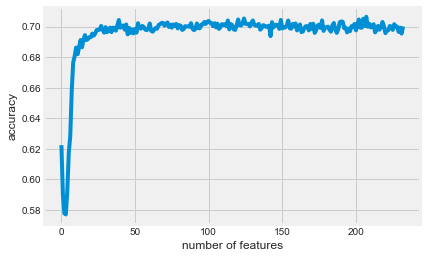

In [392]:
plt.plot(selector.grid_scores_)
plt.xlabel('number of features')
plt.ylabel('accuracy')
selector.n_features_

In [393]:
ranking=pd.DataFrame({'feature':list(x_train.columns),'rank':list(selector.ranking_)}).sort_values('rank')
ranking.head(100)

,feature,rank
0,1_Female,1
145,38_ArXiv & Preprints,1
146,38_Journal Publications,1
148,38_KDnuggets Blog,1
149,38_O'Reilly Data Newsletter,1
...,...,...
185,49_Make sure the code is well documented,1
186,49_Make sure the code is human-readable,1
187,49_Define all random seeds,1
188,49_Define relative rather than absolute file p...,1


In [401]:
x_train_selected = selector.transform(x_train)
x_test_selected = selector.transform(x_test)

In [402]:
selected_features = x_train.columns[np.where(selector.ranking_==1)]

In [403]:
x_train_selected = pd.DataFrame(x_train_selected, columns = selected_features)
x_test_selected = pd.DataFrame(x_test_selected, columns = selected_features)

In [404]:
x_train_selected.shape

(6143, 208)

In [405]:
rf = RandomForestClassifier(100, random_state=10)
scores = cross_val_score(rf, x_train_selected, y_train, cv=10, scoring='accuracy')
round(np.mean(scores),3)

0.699

변수선택 결과 - 선택한거/안한거 큰 차이가 없어 모든 변수를 고려하는걸로

# Model Selection

In [207]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=100, random_state=10)
scores = cross_val_score(rf, x_train, y_train, cv=10, scoring='accuracy')
print(round(scores.mean(),3))

0.702


In [216]:
from sklearn.svm import SVC

scores = cross_val_score(SVC(kernel='rbf'), x_train, y_train, cv = 10, scoring='accuracy', n_jobs=-1)
print(round(scores.mean(),3))

0.707


In [217]:
from sklearn.svm import SVC

scores = cross_val_score(SVC(kernel='linear'), x_train, y_train, cv = 10, scoring='accuracy', n_jobs=-1)
print(round(scores.mean(),3))

0.702


#### data scaling 후 SVM accuracy가 훨씬 나아짐

In [209]:
from sklearn.neural_network import MLPClassifier

scores = cross_val_score(MLPClassifier(hidden_layer_sizes=(100,100,100)), x_train, y_train, cv = 10, scoring='accuracy', n_jobs=-1)
print(round(scores.mean(),3))

0.622


In [210]:
from sklearn.metrics import accuracy_score

def accuracy(labels, predictions,x):
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    metric_value = accuracy_score(labels, predictions)
    return 'acc', metric_value, True

In [211]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

def model_gbm(train, train_labels, nfolds = 5, hyp = None):
    
    feature_names = list(train.columns)

    if hyp is not None:
        params = hyp
    else:
        params = {'n_estimators': 100}
    
    model = lgb.LGBMClassifier(**params, objective = 'multiclass', n_jobs = -1, random_state = 10)
    
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # prediction 넣을 df 생성
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    train = np.array(train)
    train_labels = np.array(train_labels).reshape((-1 ))
    
    valid_scores = []
    
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(train, train_labels)):
        
        X_train = train[train_indices]
        X_valid = train[valid_indices]
        y_train = train_labels[train_indices]
        y_valid = train_labels[valid_indices]
        
        model.fit(X_train, y_train,
                  eval_metric = accuracy,
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 0)
        
        valid_scores.append(model.best_score_['valid']['acc'])
        importances += model.feature_importances_ / nfolds   
        
        print('Fold {}, Valid Score: {}'.format(i+1, round(valid_scores[i], 5)))

    feat_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
    
    valid_scores = np.array(valid_scores)
    print('{} cross validation score: {} with std: {}'.format(nfolds, round(valid_scores.mean(), 5), round(valid_scores.std(), 5)))
    
    return model, feat_importances, valid_scores

In [212]:
lgbc, feat_imp, scores = model_gbm(x_train, y_train, nfolds=10)

Fold 1, Valid Score: 0.69431
Fold 2, Valid Score: 0.70732
Fold 3, Valid Score: 0.69431
Fold 4, Valid Score: 0.70244
Fold 5, Valid Score: 0.69707
Fold 6, Valid Score: 0.69055
Fold 7, Valid Score: 0.7101
Fold 8, Valid Score: 0.71987
Fold 9, Valid Score: 0.69544
Fold 10, Valid Score: 0.70799
10 cross validation score: 0.70194 with std: 0.00875


In [213]:
feat_imp.sort_values(by='importance', ascending=False).head(10)

,feature,importance
22,salary,376.6
233,Q46,222.4
220,Q35_Part_1,191.4
215,Q34_Part_2,190.0
221,Q35_Part_2,189.1
216,Q34_Part_3,183.7
217,Q34_Part_4,181.1
222,Q35_Part_3,174.8
219,Q34_Part_6,173.3
218,Q34_Part_5,155.4


같은 환경에서 했을때 SVM&LightGBM & RF이 가장 성능 good

## SVM Hyperparameter Tuning

In [222]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

tuned_parameters = {'C': [1, 2,4,8]}

grid = GridSearchCV(SVC(kernel='rbf', gamma = 'scale'), tuned_parameters, cv=5, verbose=2, scoring='accuracy')
grid.fit(x_train, y_train)
print('Best parameters found by grid search are:', grid.best_params_)
print('Best score found by grid search is:', grid.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................................. C=1, total=  11.5s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s


[CV] .............................................. C=1, total=  11.5s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  12.7s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  12.7s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  12.1s
[CV] C=2 .............................................................
[CV] .............................................. C=2, total=  13.9s
[CV] C=2 .............................................................
[CV] .............................................. C=2, total=  13.7s
[CV] C=2 .............................................................
[CV] .............................................. C=2, total=  12.6s
[CV] C=2 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.5min finished


Best parameters found by grid search are: {'C': 1}
Best score found by grid search is: 0.7074719192576917


In [223]:
scores = cross_val_score(SVC(kernel='rbf', C=1), x_train, y_train, cv = 10, scoring='accuracy', n_jobs=-1)
print(round(scores.mean(),3))

0.707


In [228]:
ksvm = SVC(kernel='rbf', gamma = 'scale' C=1)
ksvm.fit(x_train,y_train)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [230]:
yhat = ksvm.predict(x_test)
round(accuracy_score(y_test, yhat),3)

0.713

In [224]:
tuned_parameters = {'C': [1, 2,4]}

grid = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=5, verbose=2, scoring='accuracy')
grid.fit(x_train, y_train)
print('Best parameters found by grid search are:', grid.best_params_)
print('Best score found by grid search is:', grid.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................................. C=1, total=  15.5s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s remaining:    0.0s


[CV] .............................................. C=1, total=  15.4s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  15.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  15.4s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  14.1s
[CV] C=2 .............................................................
[CV] .............................................. C=2, total=  17.1s
[CV] C=2 .............................................................
[CV] .............................................. C=2, total=  16.9s
[CV] C=2 .............................................................
[CV] .............................................. C=2, total=  17.8s
[CV] C=2 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  4.6min finished


Best parameters found by grid search are: {'C': 2}
Best score found by grid search is: 0.7048673286667752


In [225]:
scores = cross_val_score(SVC(kernel='linear', C=2), x_train, y_train, cv = 10, scoring='accuracy', n_jobs=-1)
print(round(scores.mean(),3))

0.703


In [226]:
lsvm = SVC(kernel='linear', C=2)
lsvm.fit(x_train,y_train)
yhat = lsvm.predict(x_test)
round(accuracy_score(y_test, yhat),3)

0.711

## MLPClassifier Hyperparameter Tuning

In [241]:
parameters = {'max_iter': [1000,1500,2000], 
              'hidden_layer_sizes':[(100,100,100,50),(200,200,100,50),(100,100,50),(200,100,50)]}
grid = GridSearchCV(MLPClassifier(), parameters, cv=5, verbose =2, n_jobs=-1)
grid.fit(x_train, y_train)
print('Best parameters found by grid search are:', grid.best_params_)
print('Best score found by grid search is:', grid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.3min finished


Best parameters found by grid search are: {'hidden_layer_sizes': (200, 200, 100, 50), 'max_iter': 1500}
Best score found by grid search is: 0.6477291225785446


In [242]:
mlp = MLPClassifier(hidden_layer_sizes = (200, 200, 100, 50), max_iter = 1500, random_state=10)
scores = cross_val_score(mlp, x_train, y_train, cv=10, scoring='accuracy')
round(np.mean(scores),3)

0.638

In [244]:
mlp.fit(x_train, y_train)
yhat_mlp = mlp.predict(x_test)
round(accuracy_score(y_test, yhat_mlp),3)

0.623

## LightGBM Hyperparameter Tuning

In [245]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import (roc_curve, auc, accuracy_score)

gridParams = {
    'subsample': [0.5, 0.8],
    'max_depth': [20,30,40],
    'num_leaves': [20,40,60],
    'min_child_samples':[10,20,30],
    'n_estimators':[100,200]
}

mdl = lgb.LGBMClassifier()

scoring = {'ACC': 'accuracy'}

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=2, cv=5, scoring=scoring, n_jobs=-1, refit='ACC')
# Run the grid
grid.fit(np.array(x_train), np.array(y_train))

print('Best parameters found by grid search are:', grid.best_params_)
print('Best score found by grid search is:', grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  8.3min finished


Best parameters found by grid search are: {'max_depth': 20, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 20, 'subsample': 0.5}
Best score found by grid search is: 0.7084486407292854


In [247]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

def model_gbm(train, train_labels, nfolds = 10, hyp = None):
    
    feature_names = list(train.columns)

    if hyp is not None:
        params = hyp
    else:
        params = {'n_estimators': 100}
    
    model = lgb.LGBMClassifier(**params, objective = 'multiclass', n_jobs = -1, random_state = 10)
    
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # prediction 넣을 df 생성
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    train = np.array(train)
    train_labels = np.array(train_labels).reshape((-1 ))
    
    valid_scores = []
    
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(train, train_labels)):
        
        X_train = train[train_indices]
        X_valid = train[valid_indices]
        y_train = train_labels[train_indices]
        y_valid = train_labels[valid_indices]
        
        model.fit(X_train, y_train,
                  eval_metric = accuracy,
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 0)
        
        valid_scores.append(model.best_score_['valid']['acc'])
        importances += model.feature_importances_ / nfolds   
        
        print('Fold {}, Valid Score: {}'.format(i+1, round(valid_scores[i], 5)))

    feat_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
    
    valid_scores = np.array(valid_scores)
    print('{} cross validation score: {} with std: {}'.format(nfolds, round(valid_scores.mean(), 5), round(valid_scores.std(), 5)))
    
    return model, feat_importances, valid_scores

In [249]:
lgbc, feat_imp, scores = model_gbm(x_train, y_train, nfolds=10, hyp = {'max_depth': 20, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 20, 'subsample': 0.5})

Fold 1, Valid Score: 0.69268
Fold 2, Valid Score: 0.68618
Fold 3, Valid Score: 0.72683
Fold 4, Valid Score: 0.70081
Fold 5, Valid Score: 0.68078
Fold 6, Valid Score: 0.70847
Fold 7, Valid Score: 0.72964
Fold 8, Valid Score: 0.70195
Fold 9, Valid Score: 0.69707
Fold 10, Valid Score: 0.71778
10 cross validation score: 0.70422 with std: 0.01561


In [250]:
yhat = lgbc.predict(x_test)
round(accuracy_score(y_test, yhat),3)

0.708

In [251]:
feat_imp.sort_values(by='importance', ascending=False).head(15)

,feature,importance
22,salary,240.6
233,Q46,142.0
216,Q34_Part_3,122.2
221,Q35_Part_2,120.0
215,Q34_Part_2,119.8
217,Q34_Part_4,111.3
222,Q35_Part_3,110.4
220,Q35_Part_1,107.0
232,Q43,98.9
218,Q34_Part_5,98.3


LGBM - 오버피팅 X!

## RF Hyperparameter Tuning

In [233]:
from sklearn.model_selection import GridSearchCV
grid_params = {
    'n_estimators':[100,200,300,400],
    'max_depth':[20,50,80],
    'max_features':['auto','log2']
}

rf = RandomForestClassifier(random_state=10)

grid = GridSearchCV(rf,param_grid = grid_params, cv=5, verbose=2, scoring='accuracy')
grid.fit(x_train,y_train)
print('Best parameters found by grid search are:', grid.best_params_)
print('Best score found by grid search is:', grid.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] max_depth=20, max_features=auto, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=20, max_features=auto, n_estimators=100, total=   1.4s
[CV] max_depth=20, max_features=auto, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=20, max_features=auto, n_estimators=100, total=   1.4s
[CV] max_depth=20, max_features=auto, n_estimators=100 ...............
[CV]  max_depth=20, max_features=auto, n_estimators=100, total=   1.3s
[CV] max_depth=20, max_features=auto, n_estimators=100 ...............
[CV]  max_depth=20, max_features=auto, n_estimators=100, total=   1.3s
[CV] max_depth=20, max_features=auto, n_estimators=100 ...............
[CV]  max_depth=20, max_features=auto, n_estimators=100, total=   1.4s
[CV] max_depth=20, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=20, max_features=auto, n_estimators=200, total=   2.8s
[CV] max_depth=20, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=20, max_features=auto, n_estimators=200, total=   2.7s
[CV] max_depth=20, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=20, max_features=auto, n_estimators=200, total=   2.6s
[CV] max_depth=20, max_features=auto, n_estimators=200 ...............
[CV]  

[CV]  max_depth=50, max_features=auto, n_estimators=400, total=   6.4s
[CV] max_depth=50, max_features=log2, n_estimators=100 ...............
[CV]  max_depth=50, max_features=log2, n_estimators=100, total=   1.6s
[CV] max_depth=50, max_features=log2, n_estimators=100 ...............
[CV]  max_depth=50, max_features=log2, n_estimators=100, total=   1.2s
[CV] max_depth=50, max_features=log2, n_estimators=100 ...............
[CV]  max_depth=50, max_features=log2, n_estimators=100, total=   1.1s
[CV] max_depth=50, max_features=log2, n_estimators=100 ...............
[CV]  max_depth=50, max_features=log2, n_estimators=100, total=   1.0s
[CV] max_depth=50, max_features=log2, n_estimators=100 ...............
[CV]  max_depth=50, max_features=log2, n_estimators=100, total=   0.9s
[CV] max_depth=50, max_features=log2, n_estimators=200 ...............
[CV]  max_depth=50, max_features=log2, n_estimators=200, total=   1.9s
[CV] max_depth=50, max_features=log2, n_estimators=200 ...............
[CV]  

[CV]  max_depth=80, max_features=log2, n_estimators=400, total=   4.5s
[CV] max_depth=80, max_features=log2, n_estimators=400 ...............
[CV]  max_depth=80, max_features=log2, n_estimators=400, total=   5.3s
[CV] max_depth=80, max_features=log2, n_estimators=400 ...............
[CV]  max_depth=80, max_features=log2, n_estimators=400, total=   4.1s


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  6.1min finished


Best parameters found by grid search are: {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 100}
Best score found by grid search is: 0.7020999511639264


In [234]:
rf = RandomForestClassifier(100, random_state=10, max_depth=20)
scores = cross_val_score(rf, x_train, y_train, cv=10, scoring='accuracy')
round(np.mean(scores),3)

0.702

In [235]:
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [236]:
yhat_rf = rf.predict(x_test)
round(accuracy_score(y_test, yhat_rf),3)

0.702

In [237]:
feature_imp = pd.Series(rf.feature_importances_, index=x_train.columns).sort_values(ascending = False)
feature_imp[0:15]

6_0_Data Scientist    0.042560
salary                0.024837
Q46                   0.019246
Q34_Part_2            0.016822
Q35_Part_2            0.016531
Q35_Part_1            0.016531
Q34_Part_4            0.015159
Q34_Part_3            0.014819
Q35_Part_3            0.014550
Q34_Part_1            0.013893
Q10                   0.013431
Q34_Part_6            0.013295
Q34_Part_5            0.013221
age                   0.013116
Q43                   0.012909
dtype: float64

RF도 오버피팅X!

## 변수 중요도 
- RF 와 XGboost 크게 다르지 않았음
(공통부분 - 순서 상관 X)


    1. Data Scientist
      ==> 당연히 직무가 data scientist라면 자신이 data scientist에 confident할 확률이 높음  
    
    
    2. salary 
      ==> (각 나라 대비)연봉이 높을수록 confidence가 더 높았음 - 자신감 있는 자에게 고액의 연봉이 지급됨  
    
    
    3. Q46. Approximately what percent of your data projects involve exploring model insights?
        ==> (Model Insights가 무슨 뜻인지는 잘 모르겠으나) Model을 선택하고 결과값을 분석하는 데에 많은 시간을 쏟는 사람이 data science에 대한 자신감이 높음 - 전처리부터 모델링까지 마스터하였으니 해석 과정에서 더 시간을 들인다는 얘기(?)  
        
        
    4. Q35_Part2. What percentage of your current machine learning/data science training falls under each category? (Answers must add up to 100%) - Online courses (Coursera, Udemy, edX, etc.)
     ==> 온라인 course로 ML을 습득한 사람들의 자신감이 높은 편  
    
    
    5. Q34_Part2. During a typical data science project at work or school, approximately what proportion of your time is devoted to the following? (Answers must add up to 100%) - Cleaning data  
        ==> 데이터 전처리에 시간을 많이 쏟을 수록 data science에 자신감이 높은 편. 실제로 데이터 전처리는 데이터분석 중 가장 중요한 파트라고 생각  
        

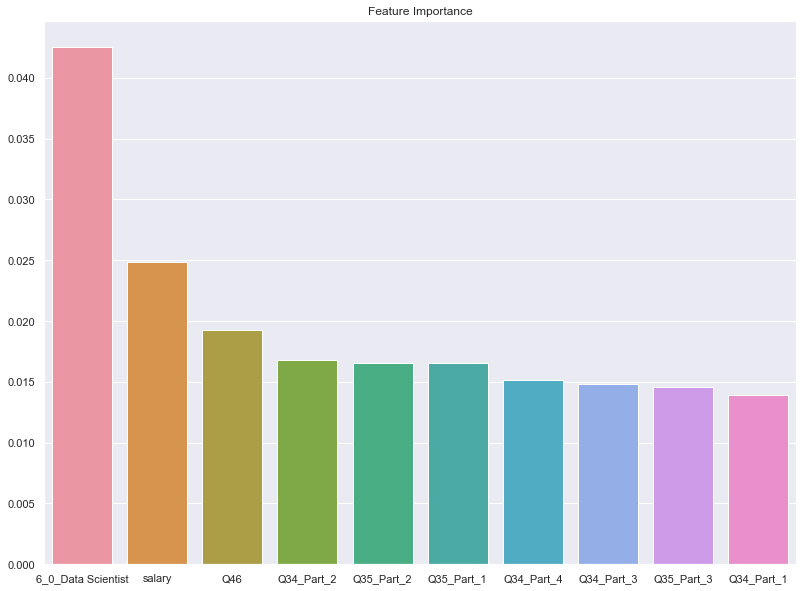

In [331]:
plt.figure(figsize=(12,10))
sns.set(font_scale = 1)
with sns.color_palette("husl", 8):
    sns.barplot(x=feature_imp[0:10].index,y=feature_imp[0:10])
plt.title("Feature Importance")
plt.show()

대체로 numeric coding이 되어있는 변수의 중요도가 높았다... 더미 변수와 numeric 변수를 함께 사용하면 중요도 산정에 영향이 많이 끼치는 걸까?

## PCA(For Visualization)

In [188]:
from sklearn.decomposition import PCA

In [205]:
pca = PCA(n_components=3)

In [206]:
PC = pca.fit_transform(df_labeled.iloc[:,:-1])
PC = pd.DataFrame(data = PC
             , columns = ['PC1', 'PC2','PC3'])

In [207]:
PC = pd.concat([PC, df_labeled.iloc[:,-1]],axis=1)
PC

,PC1,PC2,PC3,Confidence
0,-0.868245,-1.246860,-0.840581,2
1,-1.782382,-0.720384,0.745571,1
2,-2.673808,-0.671367,-0.029597,1
3,-0.136840,1.129013,0.704823,1
4,0.383034,0.523111,0.491699,1
...,...,...,...,...
8772,0.155400,-0.253572,0.841490,1
8773,-2.594172,-0.159733,-1.326289,1
8774,-0.060769,1.046665,0.571691,2
8775,-2.749853,-0.538387,0.868520,1


In [281]:
# import random
# n =random.sample(range(PC.shape[0]), 2000)
# sample=PC.iloc[n]

In [285]:
X = PC.iloc[:,:-1].copy()
y = PC.iloc[:,-1].copy()

X = np.array(X)
y = np.array(y)

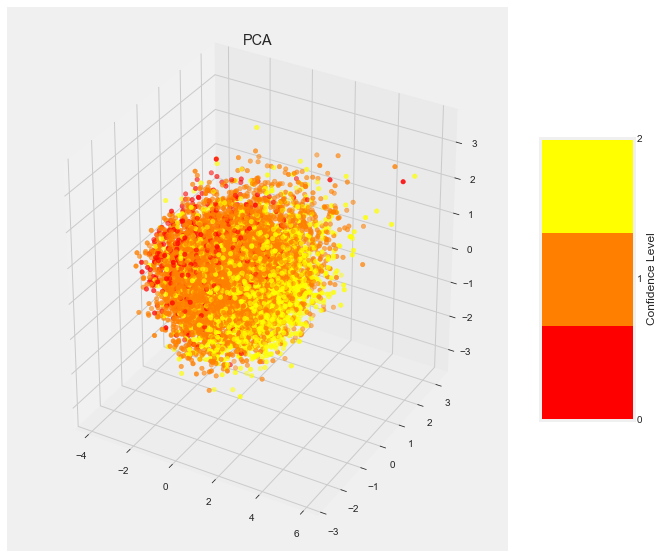

In [305]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
    
p = ax.scatter(X[:, 0], X[:, 1], X[:,2], c=y, cmap=plt.cm.get_cmap('autumn', 3))
    
fig.colorbar(p, aspect = 3, ticks = [0,1,2], label='Confidence Level')
plt.title('PCA')
plt.show()